In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib as mpl
import json
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
# Default settings
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use("seaborn-darkgrid")
plt.rcParams.update({'font.size': 20})

C:\Users\dicky1031\AppData\Local\Temp\ipykernel_24312\2527255600.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


## Format Setting

In [2]:
date = "20230912"
subject = 'KB'
exp = 'VM'
SDS1_time_resolution = 0.10404 # [sec/point]
SDS2_time_resolution = 0.1 # [sec/point]
baseline_end = 60 # [sec]
exp_end = 75 #[sec]
recovery_end = 675 #[sec]

In [ ]:
# moving avg
def before_after_moving_average(data, avg_points=30):
    '''
    1D array
    '''
    process_data = data.copy()
    original_data = data.copy()
    def moving_average(a, n=3):
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n
    process_data[avg_points - 1:] = moving_average(process_data, n = avg_points)
    process_data[:avg_points - 1] = process_data[avg_points - 1 : avg_points - 2 + avg_points]
    return original_data, process_data

## Get processed data

In [3]:
# get processed long ch. data
data2 = pd.read_csv(os.path.join("dataset", subject, "SDS2", date, exp, f'in_vivo_result_{exp}.csv')) # wl resolution = 0.171 nm, time resolution = 0.1 secs
np_data2 = data2.to_numpy()[:round(recovery_end/SDS2_time_resolution),2:]
used_wl2 = [float(k.split('nm')[0]) for k in data2.keys().to_list()[2:]]
max_id2 = np.where(data2['peak']==1)[0]
min_id2 = np.where(data2['peak']==-1)[0]

max_id2 = max_id2[np.where(max_id2<round(recovery_end/SDS2_time_resolution))[0]]
min_id2 = min_id2[np.where(min_id2<round(recovery_end/SDS2_time_resolution))[0]]

# get processed short ch. data & sync to use same peak.
data = pd.read_csv(os.path.join("dataset", subject, "SDS1", date, exp, f'in_vivo_result_{exp}.csv')) # wl resolution = 0.171 nm, time resolution =  secs
np_data = data.to_numpy()[:round(recovery_end/SDS1_time_resolution),2:]
used_wl = [float(k.split('nm')[0]) for k in data.keys().to_list()[2:]]
max_id1 = np.where(data['peak']==1)[0]
min_id1 = np.where(data['peak']==-1)[0]

max_id1 = max_id1[np.where(max_id1<round(recovery_end/SDS1_time_resolution))[0]]
min_id1 = min_id1[np.where(min_id1<round(recovery_end/SDS1_time_resolution))[0]]

## Adjust Wavelength

In [4]:
with open(os.path.join("OPs_used", "wavelength.json"), 'r') as f:
    wavelength = json.load(f)
    wavelength = wavelength['wavelength']
wavelength = np.array(wavelength)

In [5]:
## adjust short ch.
# Cubic spline interpolation
f_interpolate = interp1d(used_wl, np_data, kind='linear', bounds_error=False, fill_value='extrapolate')
used_wl_data = f_interpolate(wavelength)

## adjust long ch.
# get cumulate wavelength index
acumulate_table = {}
accmulate_range_of_wl = 2 # [nm]
for comp_wl in wavelength:
    cumulate_index = []
    for idx, each_used_wl in enumerate(used_wl2):
        if abs(float(each_used_wl) - comp_wl) < accmulate_range_of_wl:
            cumulate_index += [idx]
    acumulate_table[comp_wl] = cumulate_index

# used cumulate wavelength index to binning
for idx, wl in enumerate(acumulate_table.keys()):
    accmulate_idx = acumulate_table[wl]
    each_wl_data = np_data2[:, accmulate_idx]
    mean_of_each_wl_data = each_wl_data.mean(1).reshape(-1,1)
    if idx == 0:
        used_wl_data2 = mean_of_each_wl_data
    else:
        used_wl_data2 = np.concatenate((used_wl_data2, mean_of_each_wl_data), axis=1)

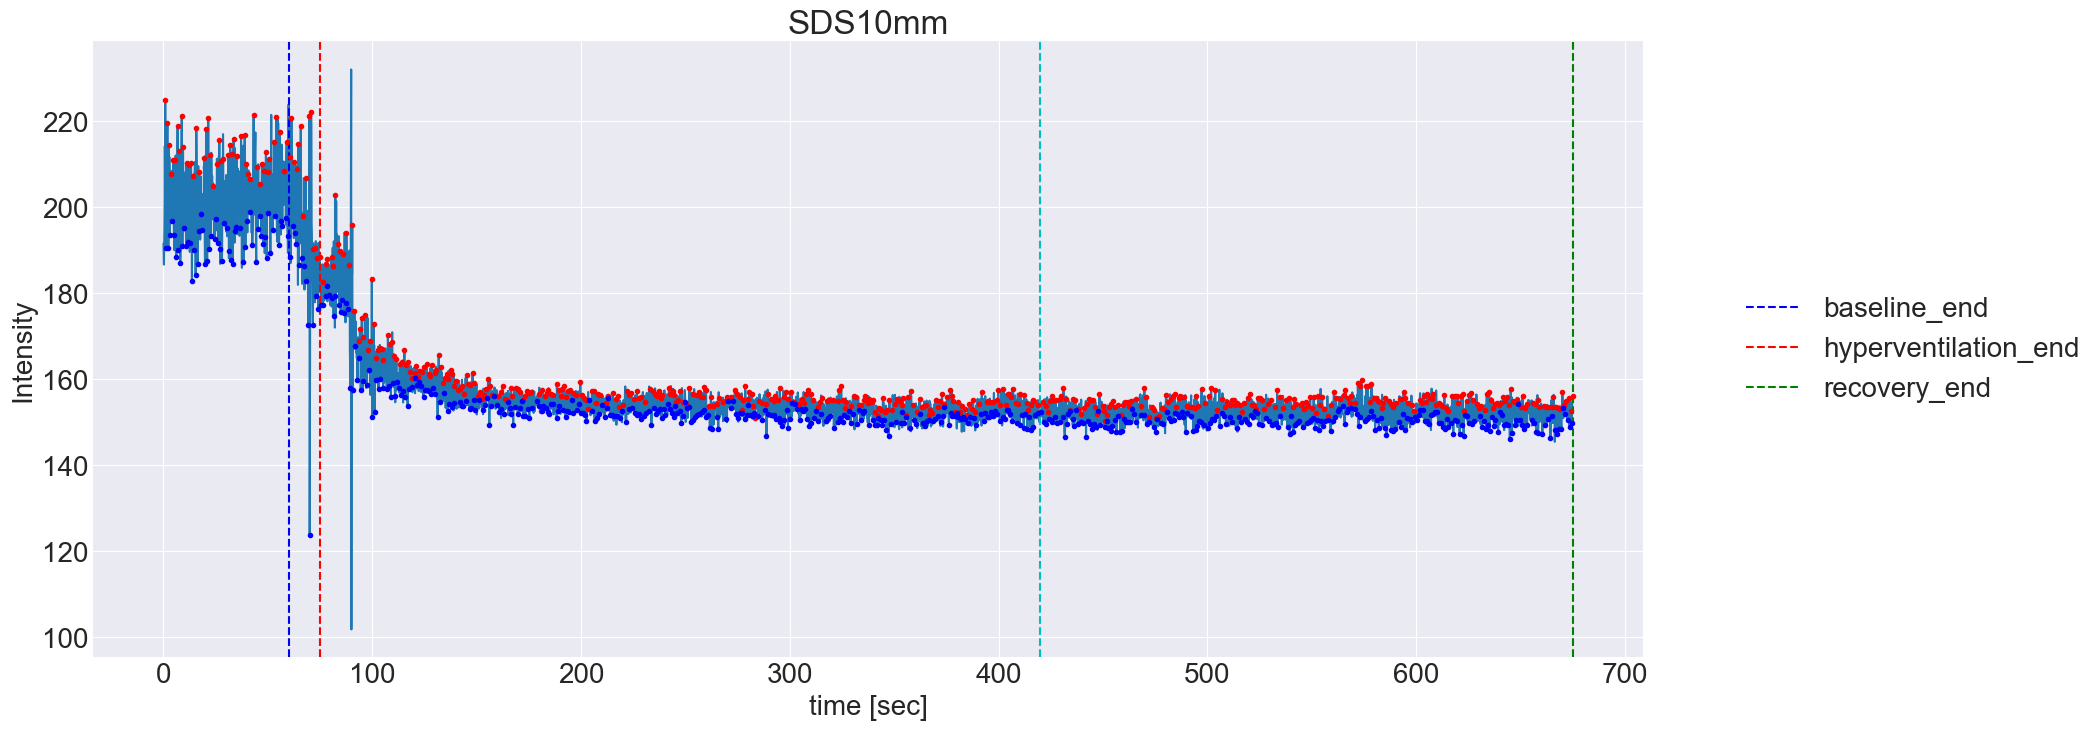

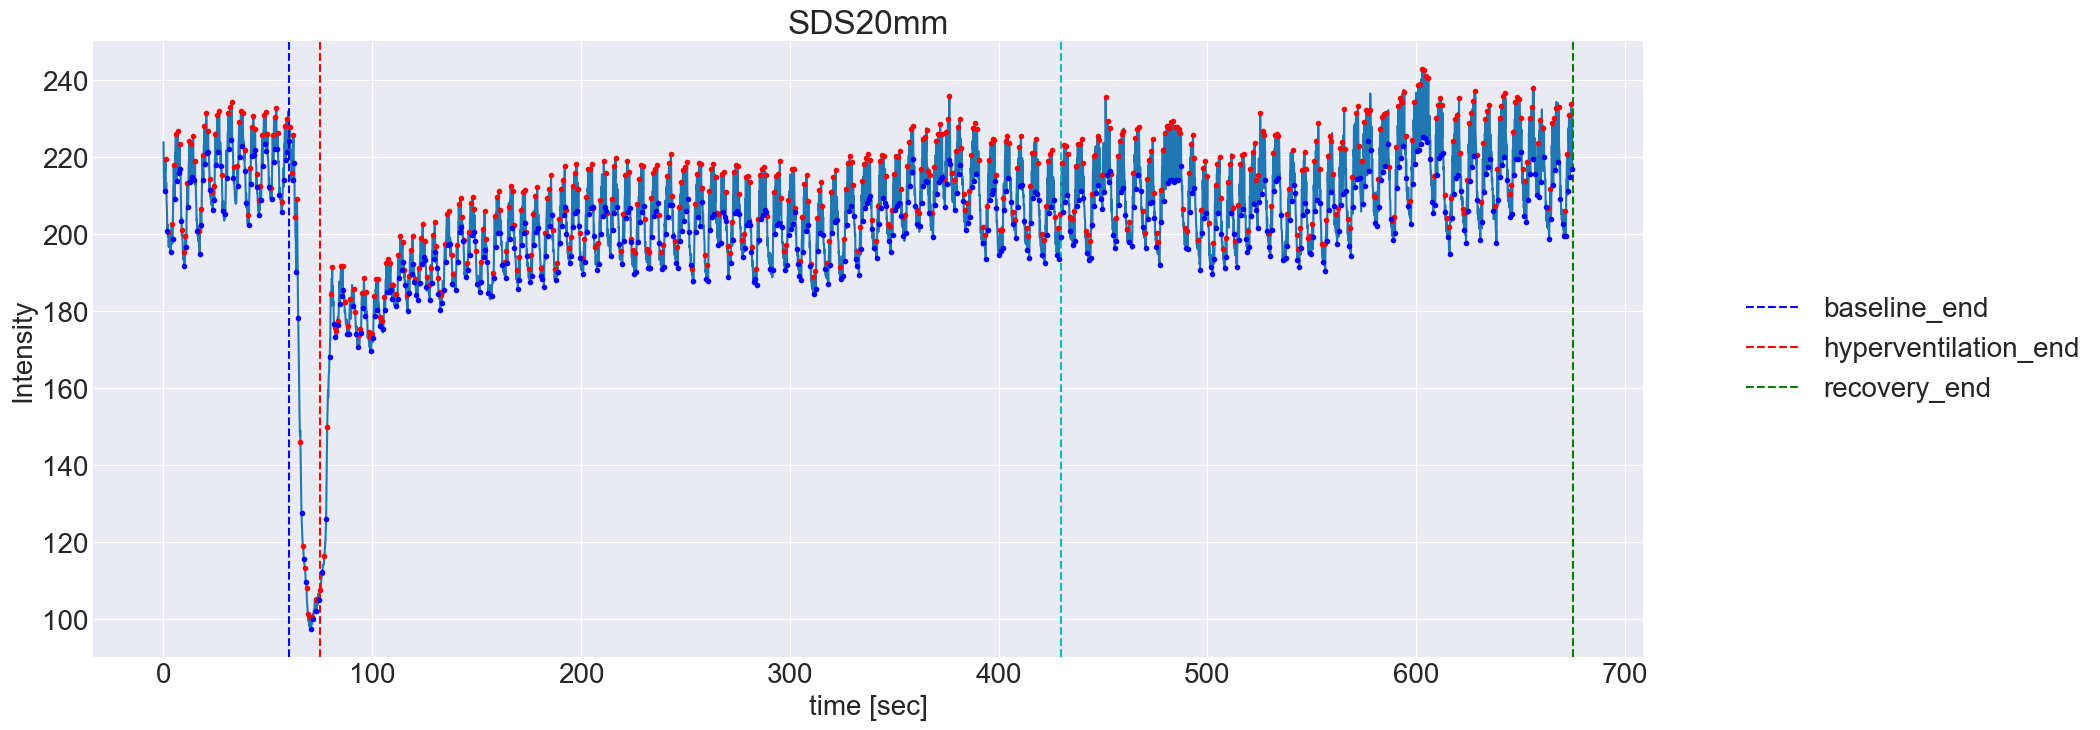

In [6]:
os.makedirs(os.path.join('pic', subject, f'{date}_invivo_result', exp), exist_ok=True)
## plot raw data
plt.figure(figsize=(20,8))
time = np.linspace(0,recovery_end, used_wl_data.shape[0])
plt.plot(time, used_wl_data.mean(1))
plt.axvline(x=420, linestyle='--', color='c')
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.plot(time[max_id1], used_wl_data.mean(1)[max_id1], 'r.')
plt.plot(time[min_id1], used_wl_data.mean(1)[min_id1], 'b.')
plt.xlabel("time [sec]")
plt.ylabel("Intensity")
plt.title('SDS10mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'raw_SDS1.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,8))
time = np.linspace(0,recovery_end, used_wl_data2.shape[0])
plt.plot(time, used_wl_data2.mean(1))
plt.axvline(x=430, linestyle='--', color='c')
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.plot(time[max_id2], used_wl_data2.mean(1)[max_id2], 'r.')
plt.plot(time[min_id2], used_wl_data2.mean(1)[min_id2], 'b.')
plt.xlabel("time [sec]")
plt.ylabel("Intensity")
plt.title('SDS20mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'raw_SDS2.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

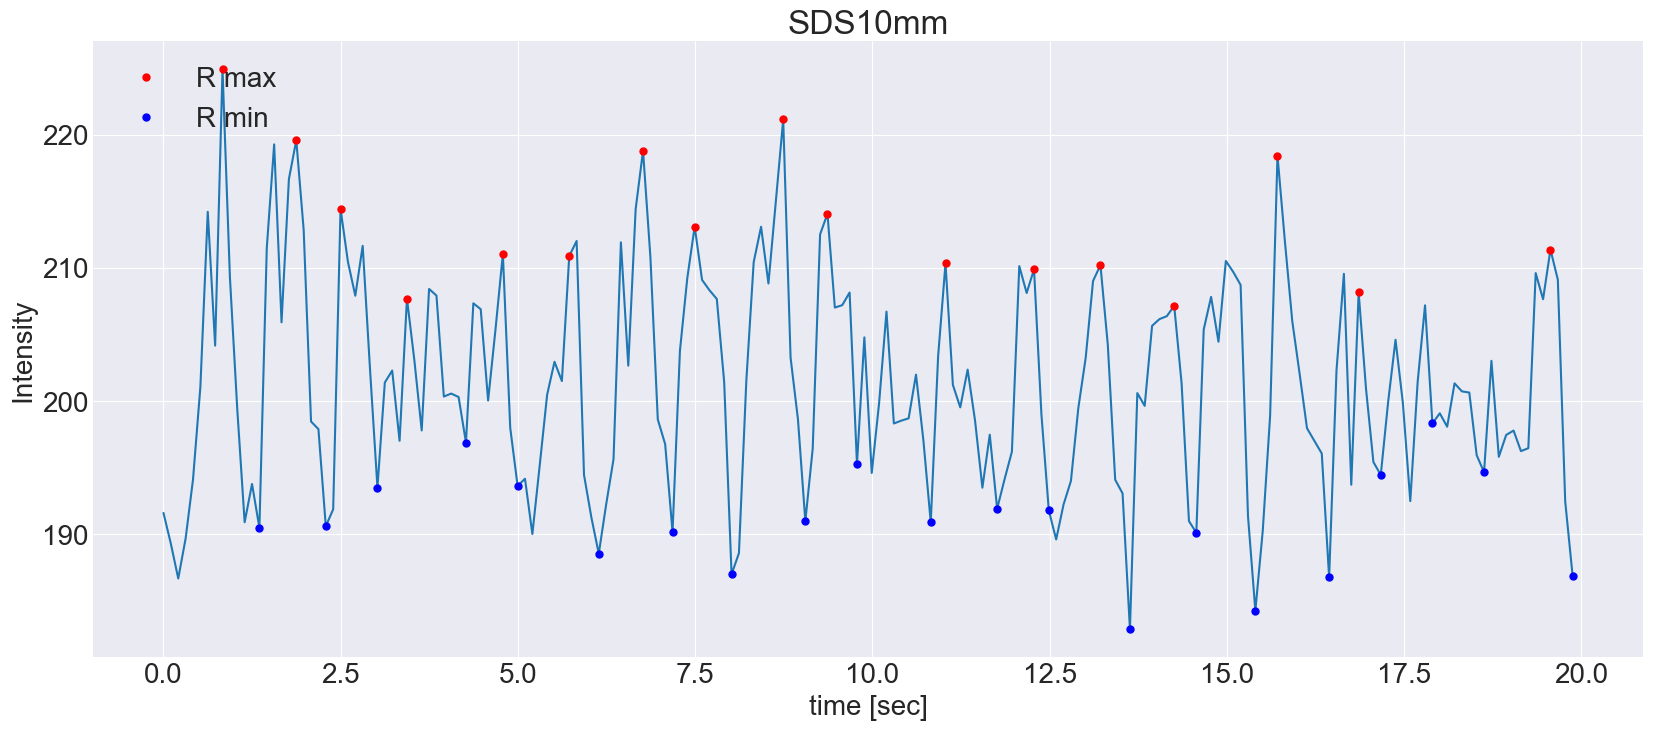

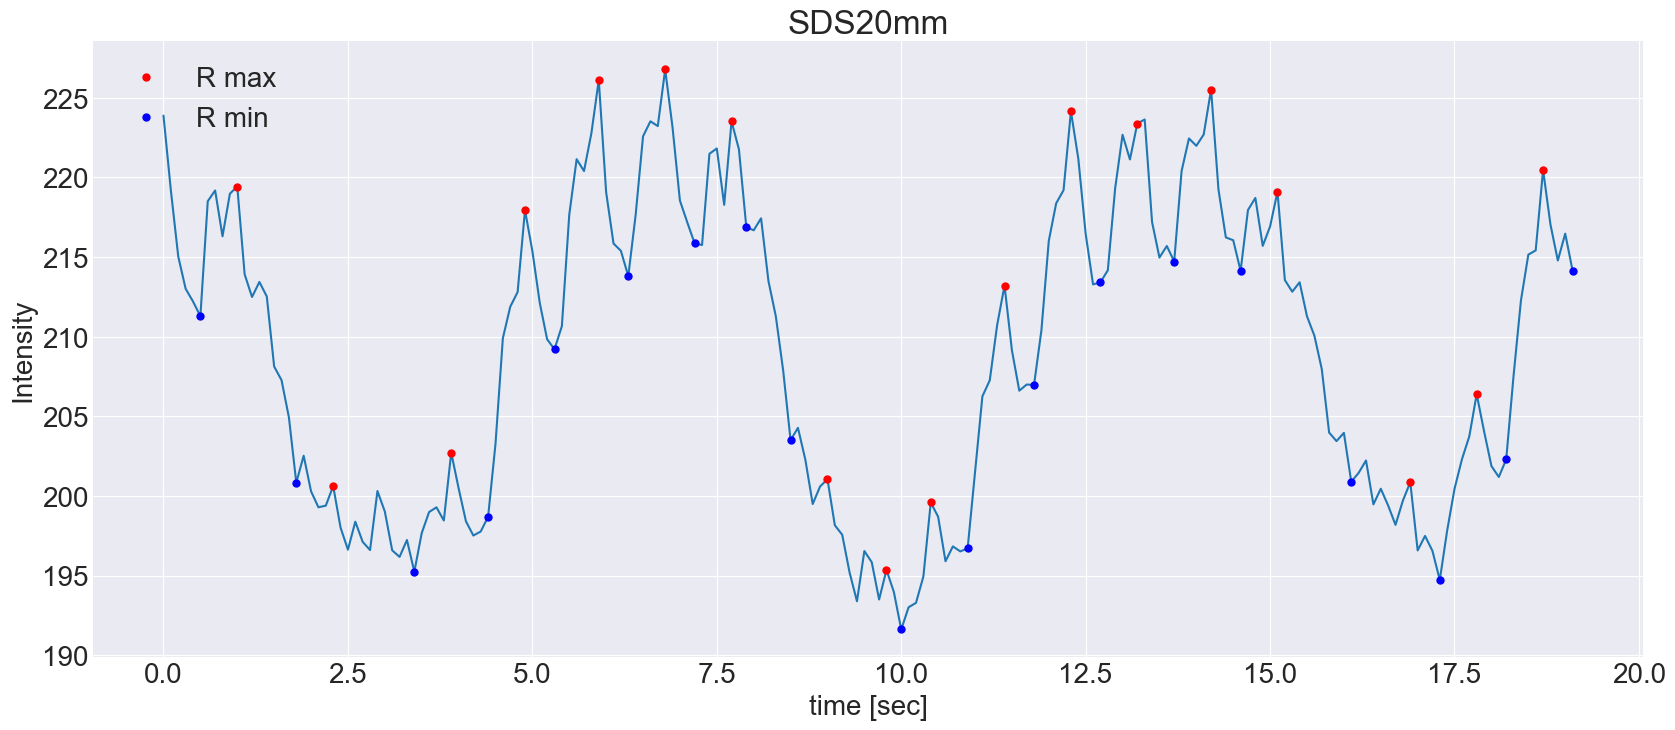

In [7]:
## plot raw data
ts = 0
td = round(20/SDS1_time_resolution)
plt.figure(figsize=(20,8))
time = np.linspace(0,recovery_end, used_wl_data.shape[0])
plt.plot(time[ts:td], used_wl_data[ts:td].mean(1))
plt.plot(time[max_id1[np.where((max_id1<=td)&(max_id1>=ts))]], used_wl_data.mean(1)[max_id1[np.where((max_id1<=td)&(max_id1>=ts))]], 'r.', ms=10, label='R max')
plt.plot(time[min_id1[np.where((min_id1<=td)&(min_id1>=ts))]], used_wl_data.mean(1)[min_id1[np.where((min_id1<=td)&(min_id1>=ts))]], 'b.', ms=10, label='R min')
plt.xlabel("time [sec]")
plt.ylabel("Intensity")
plt.title('SDS10mm')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, f'raw_SDS1_{ts}_{td}.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

ts = 0
td = round(20/SDS1_time_resolution)
plt.figure(figsize=(20,8))
time = np.linspace(0,recovery_end, used_wl_data2.shape[0])
plt.plot(time[ts:td], used_wl_data2[ts:td].mean(1))
plt.plot(time[max_id2[np.where((max_id2<=td)&(max_id2>=ts))]], used_wl_data2.mean(1)[max_id2[np.where((max_id2<=td)&(max_id2>=ts))]], 'r.', ms=10, label='R max')
plt.plot(time[min_id2[np.where((min_id2<=td)&(min_id2>=ts))]], used_wl_data2.mean(1)[min_id2[np.where((min_id2<=td)&(min_id2>=ts))]], 'b.', ms=10, label='R min')
plt.xlabel("time [sec]")
plt.ylabel("Intensity")
plt.title('SDS20mm')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, f'raw_SDS2_{ts}_{td}.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

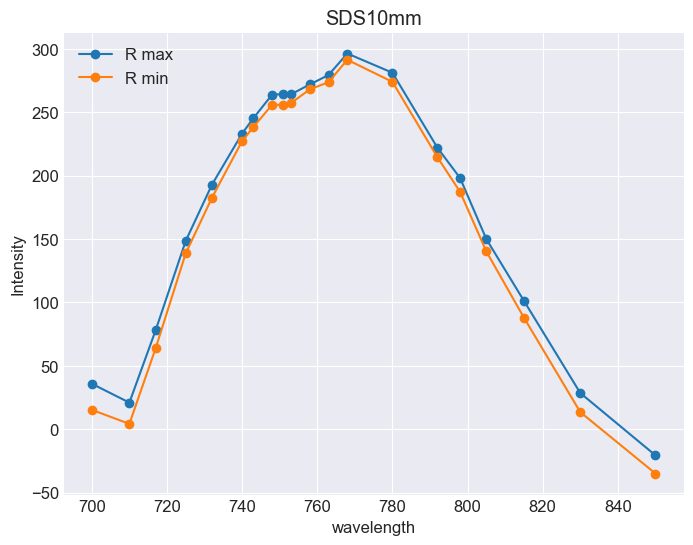

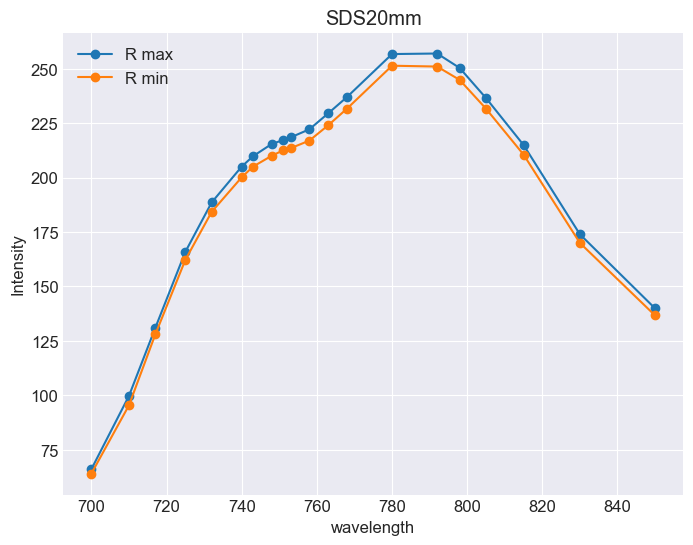

In [8]:
plt.rcParams.update({'font.size': 12})
ts = 180
td = round(200/SDS1_time_resolution)
plt.figure(figsize=(8,6))
plt.plot(wavelength, used_wl_data[max_id1[np.where((max_id1<=td)&(max_id1>=ts))]].mean(0), 'o-', label='R max')
plt.plot(wavelength, used_wl_data[min_id1[np.where((min_id1<=td)&(min_id1>=ts))]].mean(0), 'o-', label='R min')
plt.xlabel('wavelength')
plt.ylabel('Intensity')
plt.title('SDS10mm')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, f'raw_SDS1_{ts}_{td}_spec.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

ts = 180
td = round(200/SDS2_time_resolution)
plt.figure(figsize=(8,6))
plt.plot(wavelength, used_wl_data2[max_id2[np.where((max_id2<=td)&(max_id2>=ts))]].mean(0), 'o-', label='R max')
plt.plot(wavelength, used_wl_data2[min_id2[np.where((min_id2<=td)&(min_id2>=ts))]].mean(0), 'o-', label='R min')
plt.xlabel('wavelength')
plt.ylabel('Intensity')
plt.title('SDS20mm')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, f'raw_SDS2_{ts}_{td}_spec.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.rcParams.update({'font.size': 20})

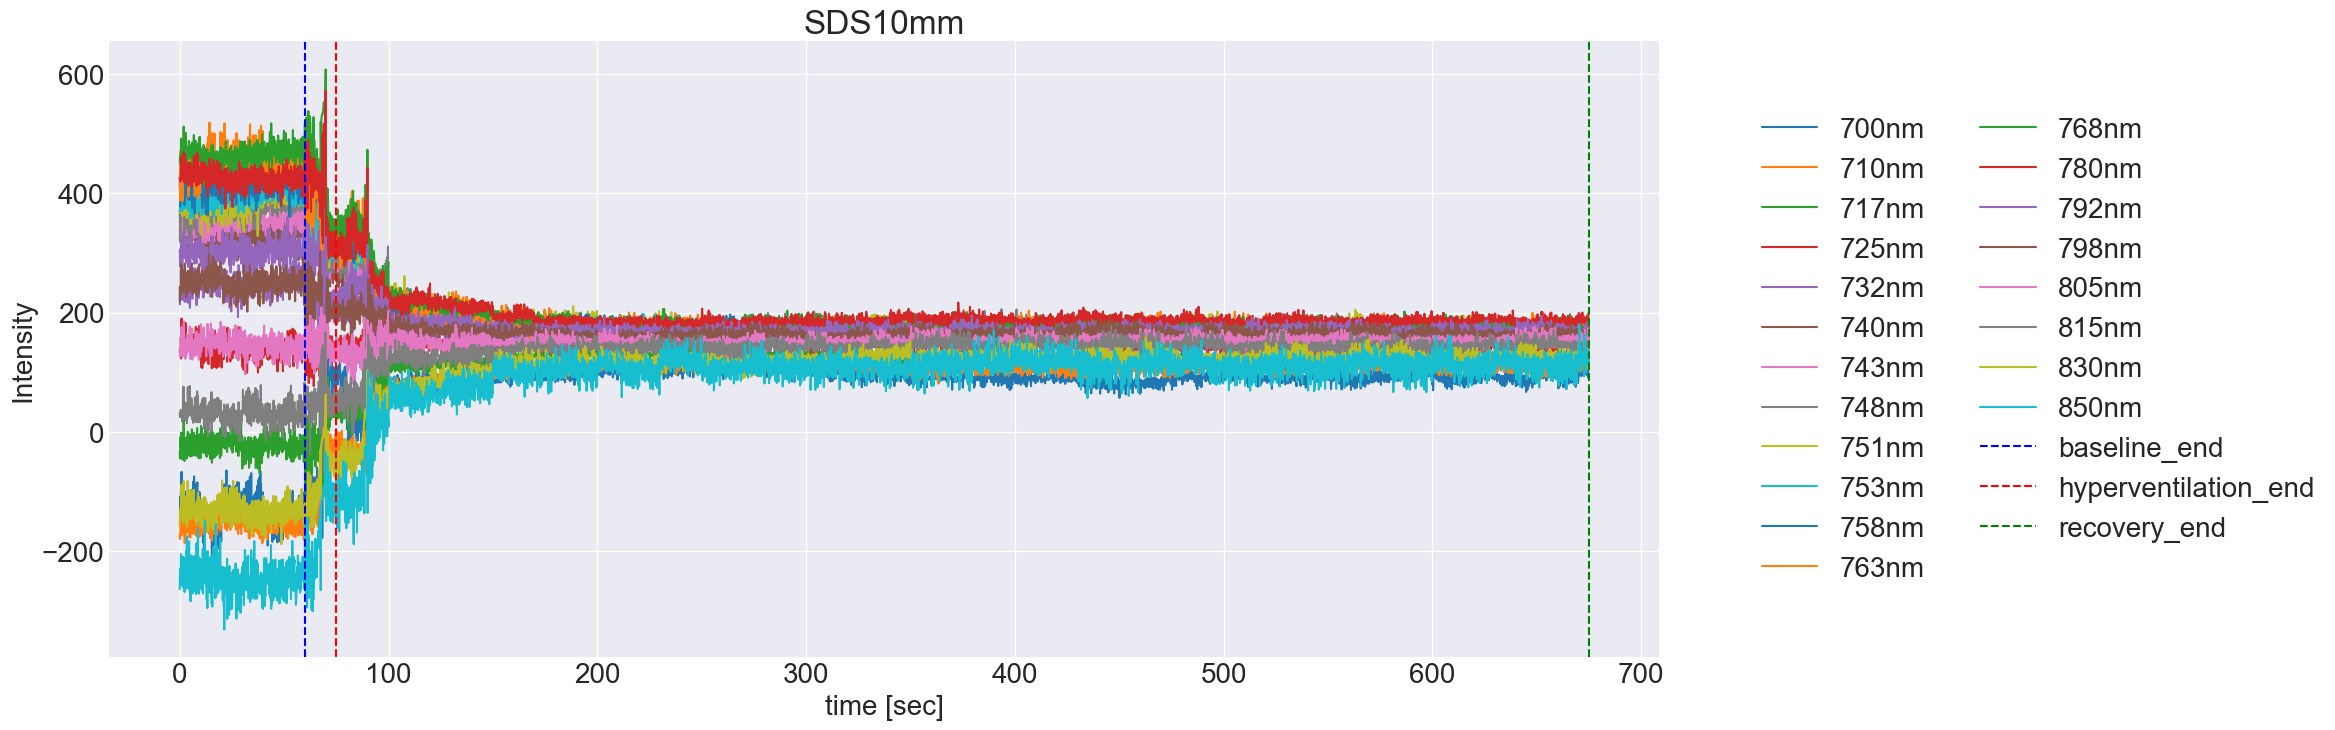

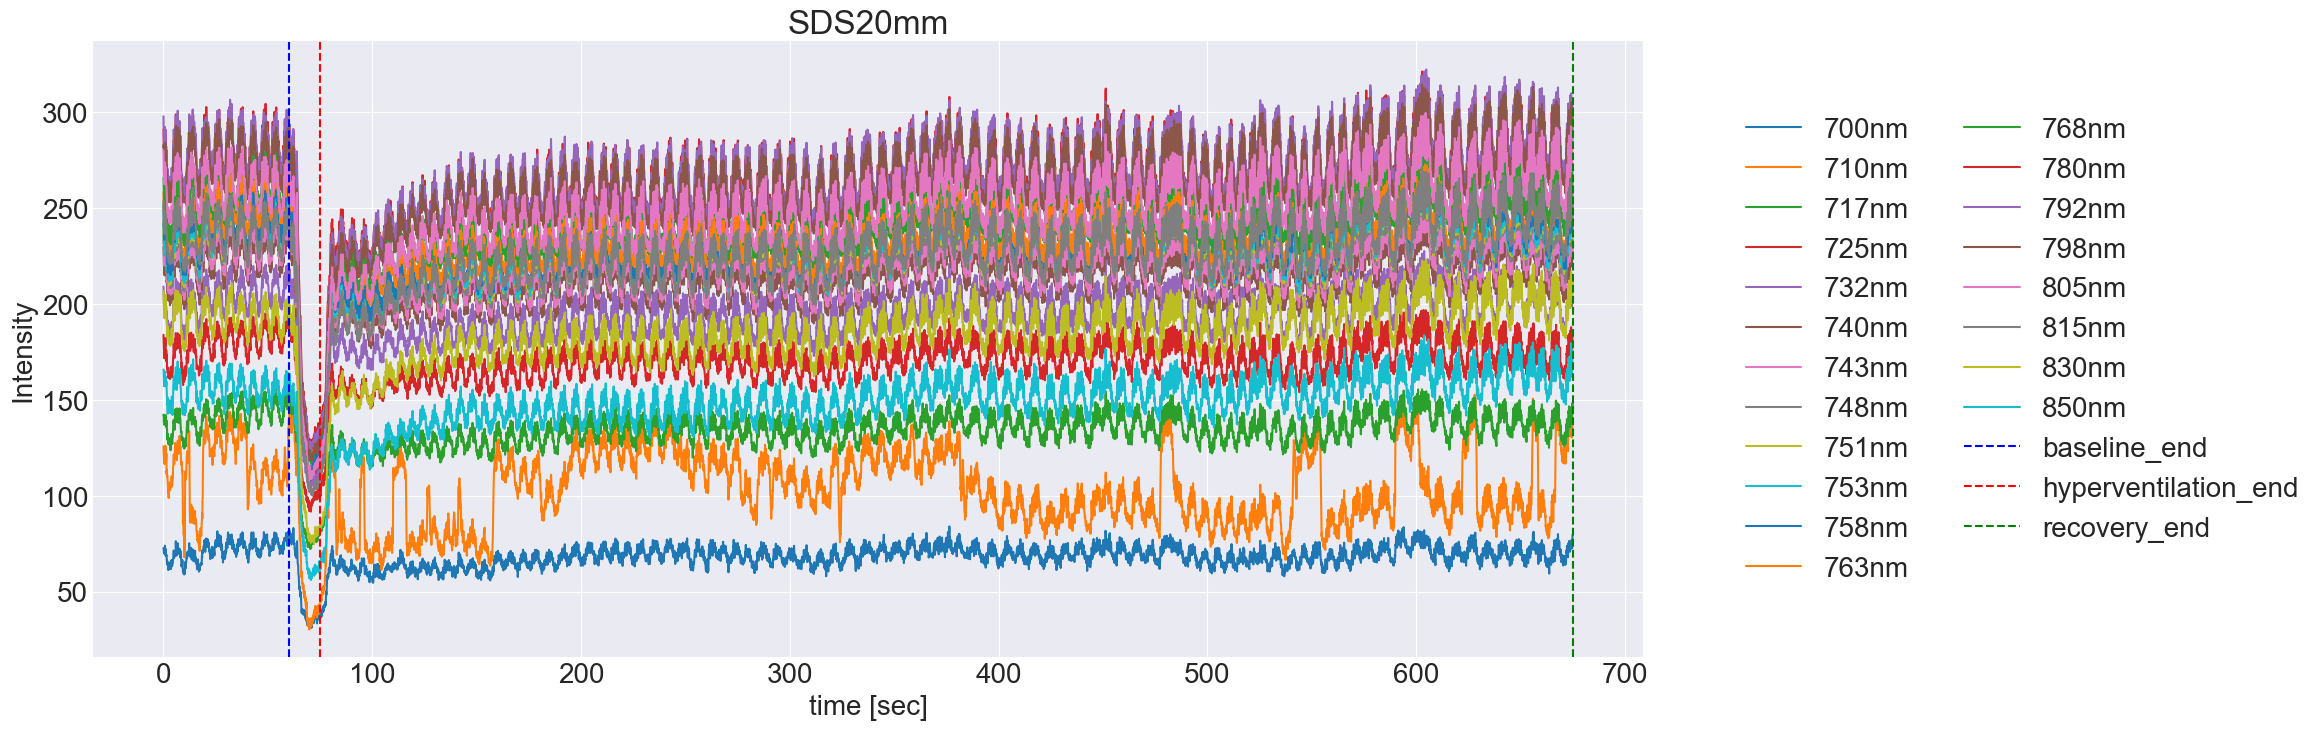

In [9]:
# plot all the wavelength
plt.figure(figsize=(20,8))
time = [i*SDS1_time_resolution for i in range(used_wl_data.shape[0])]
for i in range(20):
    plt.plot(time, used_wl_data[:,i], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True, ncol=2)
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS10mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'raw_each_wl_SDS1.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,8))
time = [i*SDS2_time_resolution for i in range(used_wl_data2.shape[0])]
for i in range(20):
    plt.plot(time,used_wl_data2[:,i], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True, ncol=2)
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS20mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'raw_each_wl_SDS2.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

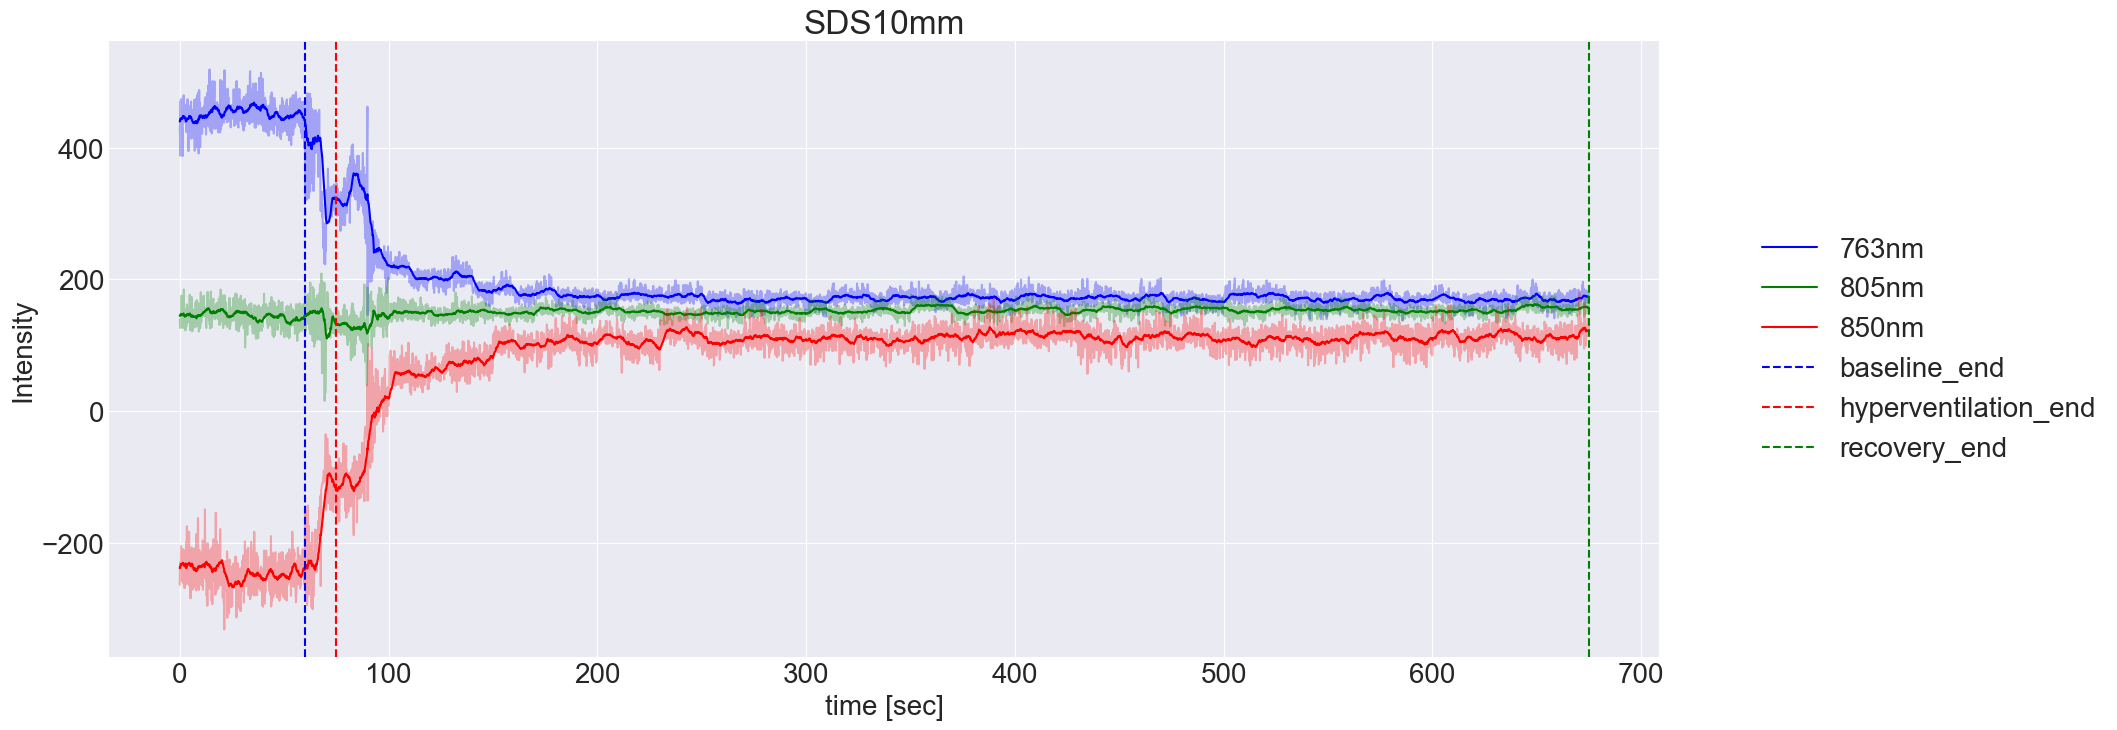

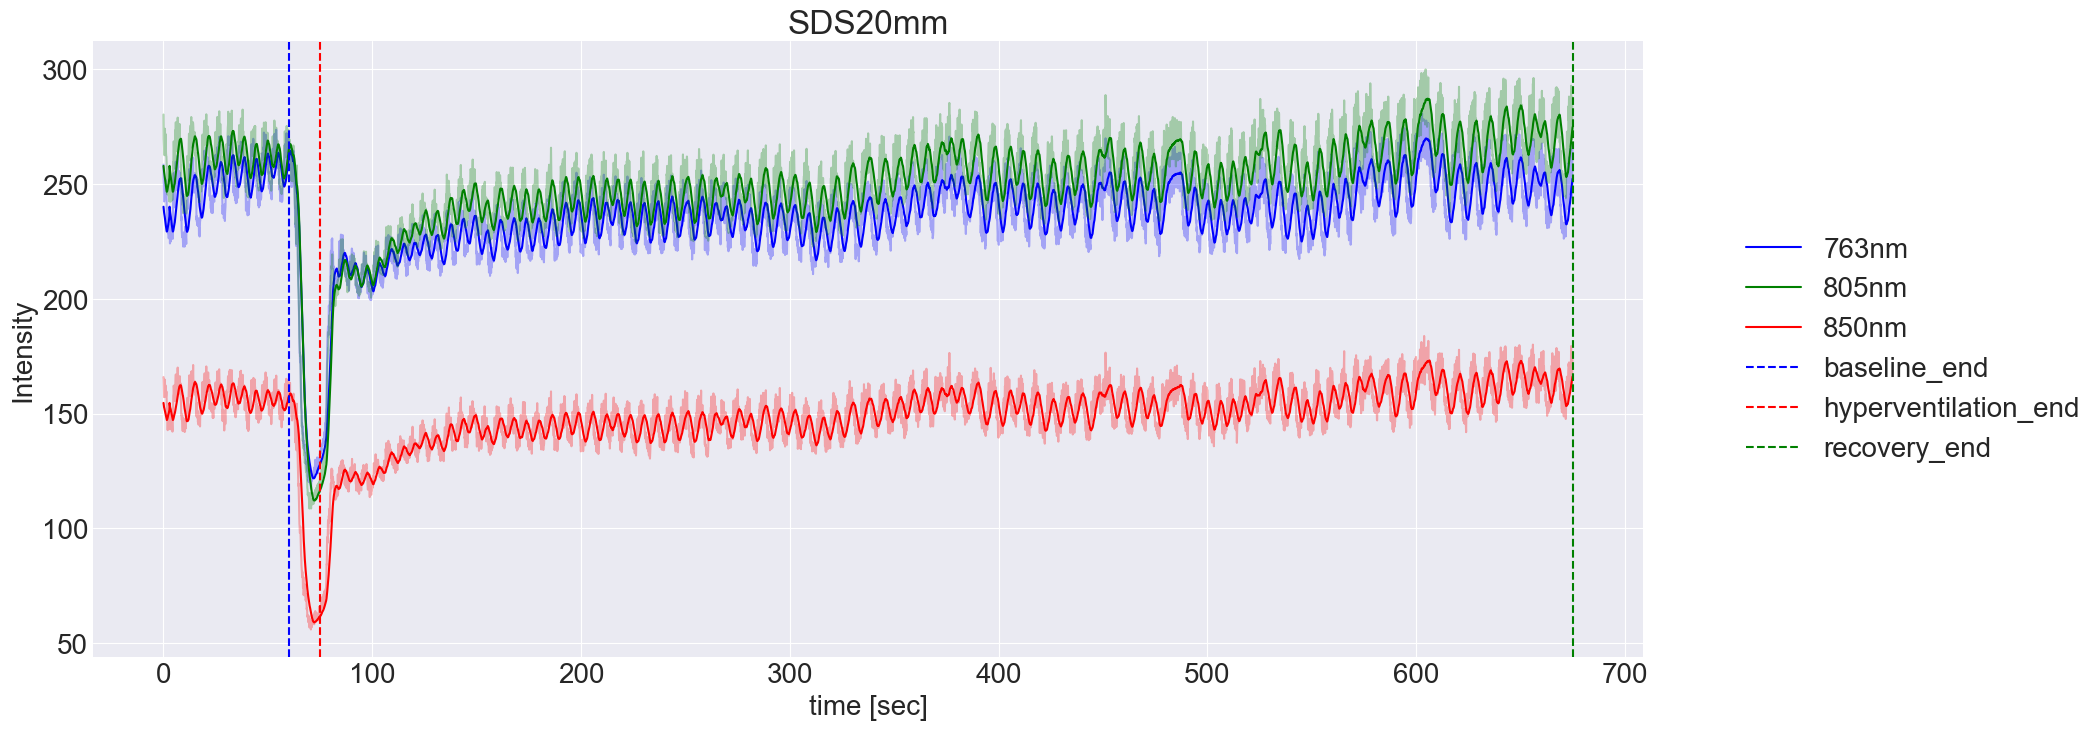

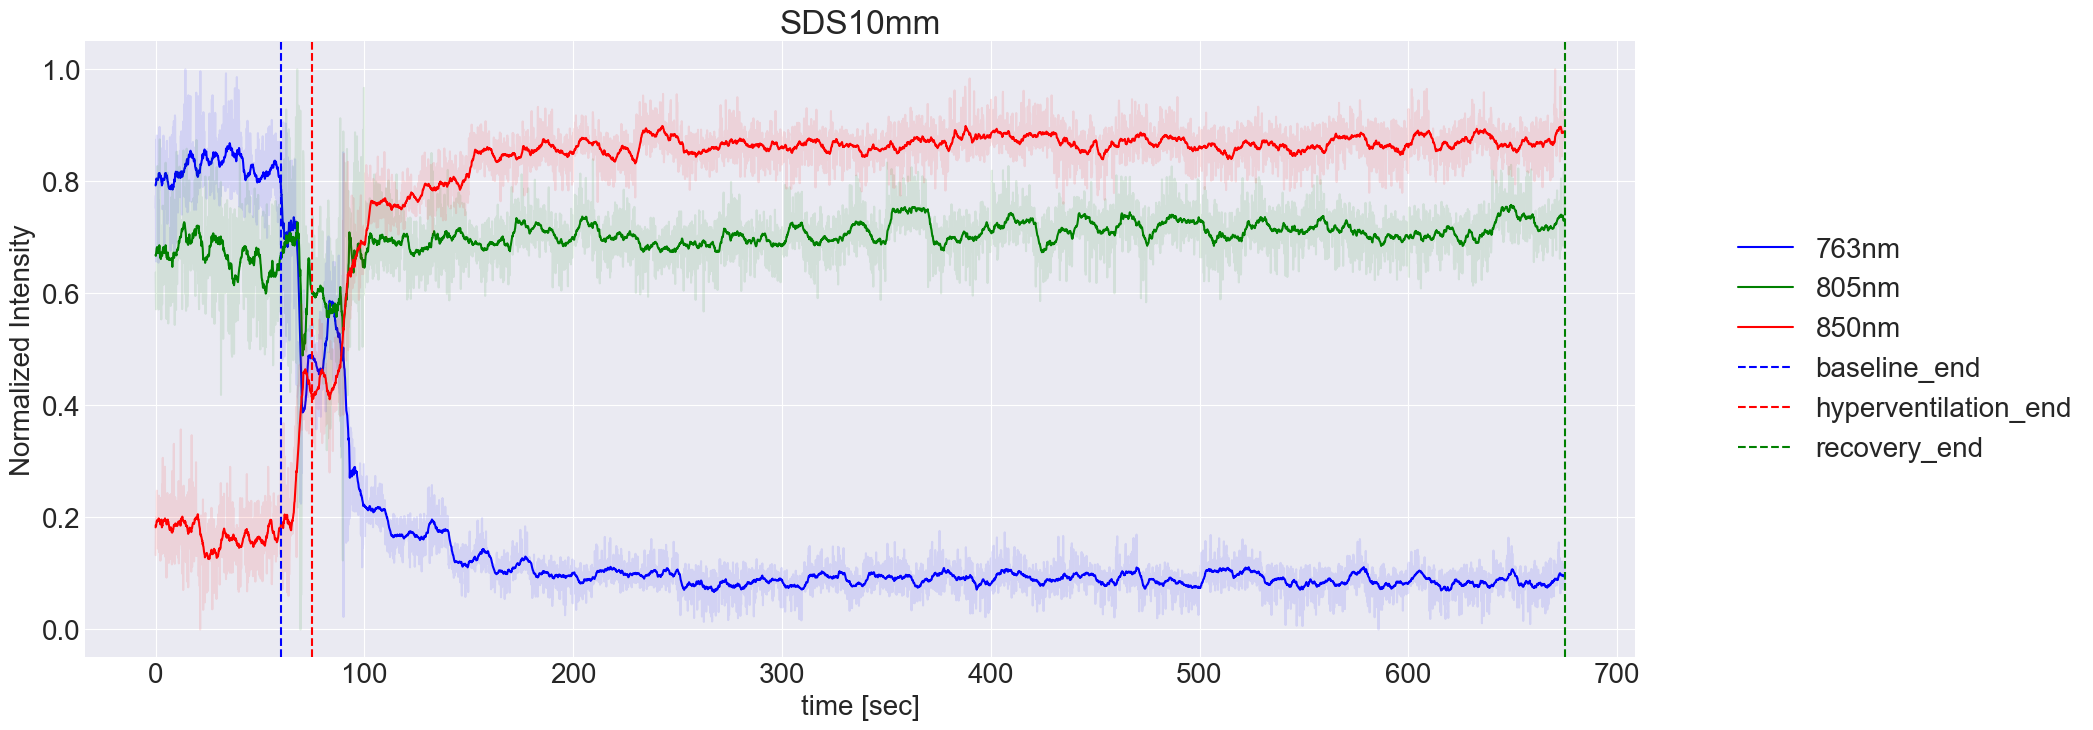

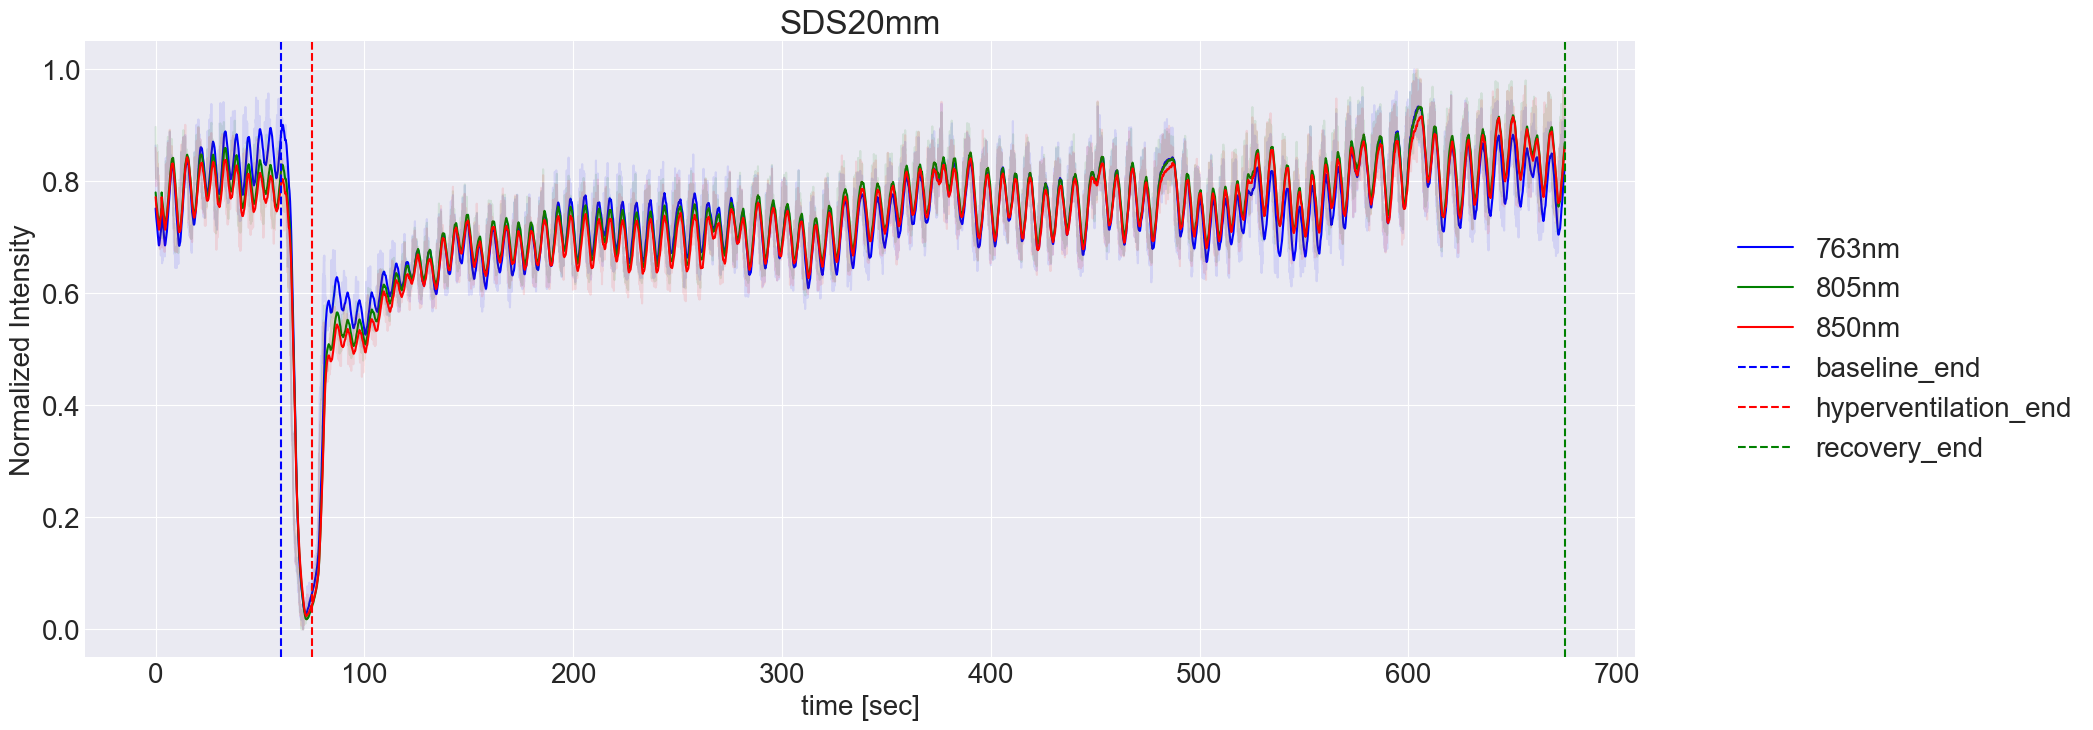

In [11]:
# plot interested wavelength [763nm , 805nm, 850nm]
plt.figure(figsize=(20,8))
time = [i*SDS1_time_resolution for i in range(used_wl_data.shape[0])]
color = ['blue', 'green', 'red']
for c_idx, i in enumerate([np.where(wavelength==763)[0][0], np.where(wavelength==805)[0][0], np.where(wavelength==850)[0][0]]):
    BF_used_wl_data, AF_used_wl_data = before_after_moving_average(data=used_wl_data[:,i])
    plt.plot(time, BF_used_wl_data, color=color[c_idx], alpha=0.3)
    plt.plot(time, AF_used_wl_data, color=color[c_idx], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS10mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'raw_focus_wl_SDS1.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,8))
time = [i*SDS2_time_resolution for i in range(used_wl_data2.shape[0])]
color = ['blue', 'green', 'red']
for c_idx, i in enumerate([np.where(wavelength==763)[0][0], np.where(wavelength==805)[0][0], np.where(wavelength==850)[0][0]]):
    BF_used_wl_data, AF_used_wl_data = before_after_moving_average(data=used_wl_data2[:,i])
    plt.plot(time, BF_used_wl_data, color=color[c_idx], alpha=0.3)
    plt.plot(time, AF_used_wl_data, color=color[c_idx], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS20mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'raw_focus_wl_SDS2.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()



plt.figure(figsize=(20,8))
time = [i*SDS1_time_resolution for i in range(used_wl_data.shape[0])]
color = ['blue', 'green', 'red']
for c_idx, i in enumerate([np.where(wavelength==763)[0][0], np.where(wavelength==805)[0][0], np.where(wavelength==850)[0][0]]):
    BF_used_wl_data, AF_used_wl_data = before_after_moving_average(data=used_wl_data[:,i])
    plt.plot(time, (BF_used_wl_data- BF_used_wl_data.min())/(BF_used_wl_data.max()-BF_used_wl_data.min()), color=color[c_idx], alpha=0.1)
    plt.plot(time, (AF_used_wl_data- BF_used_wl_data.min())/(BF_used_wl_data.max()-BF_used_wl_data.min()), color=color[c_idx], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.xlabel('time [sec]')
plt.ylabel('Normalized Intensity')
plt.title('SDS10mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'raw_normalized_focus_wl_SDS1.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,8))
time = [i*SDS2_time_resolution for i in range(used_wl_data2.shape[0])]
color = ['blue', 'green', 'red']
for c_idx, i in enumerate([np.where(wavelength==763)[0][0], np.where(wavelength==805)[0][0], np.where(wavelength==850)[0][0]]):
    BF_used_wl_data, AF_used_wl_data = before_after_moving_average(data=used_wl_data2[:,i])
    plt.plot(time, (BF_used_wl_data- BF_used_wl_data.min())/(BF_used_wl_data.max()-BF_used_wl_data.min()), color=color[c_idx], alpha=0.1)
    plt.plot(time, (AF_used_wl_data- BF_used_wl_data.min())/(BF_used_wl_data.max()-BF_used_wl_data.min()), color=color[c_idx], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.xlabel('time [sec]')
plt.ylabel('Normalized Intensity')
plt.title('SDS20mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'raw_normalized_focus_wl_SDS2.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()


## MBLL

In [12]:
from scipy.interpolate import CubicSpline

used_bloodConc = 138
epsilonHbO2HbPath = os.path.join("OPs_used", "absorption", "epsilon.txt")
epsilonHbO2Hb = pd.read_csv(epsilonHbO2HbPath, sep=" ", names=["wl", "HbO2", "Hb"])
cs = CubicSpline(epsilonHbO2Hb.wl.values,
                    epsilonHbO2Hb.HbO2.values, extrapolate=False)
epsilonHbO2Used = cs(wavelength)  # [cm-1/M]
cs = CubicSpline(epsilonHbO2Hb.wl.values,
                    epsilonHbO2Hb.Hb.values, extrapolate=False)
epsilonHbUsed = cs(wavelength)  # [cm-1/M]
muaHbO2Set = 2.303 * epsilonHbO2Used * (used_bloodConc / 64532) *0.1 # [1/mm]
muaHbSet = 2.303 * epsilonHbUsed * (used_bloodConc / 64500) *0.1  # [1/mm]

ijv_ppath = np.load(os.path.join("OPs_used", "ijv_small_spec_ppath_set_SDS20.npy"))


In [13]:
plt.rcParams.update({'font.size': 12})
os.makedirs(os.path.join('pic', subject, f'{date}_invivo_result', 'MBLL'), exist_ok=True)
base_time = 10 # sec
average_time = 10
time_resolution = SDS1_time_resolution
time_resolution2 = SDS2_time_resolution
based_sds1_ijv_small = used_wl_data[max_id1[np.where(abs(max_id1-round(base_time/time_resolution))<round(average_time/time_resolution))]].mean(0)
based_sds1_ijv_large = used_wl_data[min_id1[np.where(abs(min_id1-round(base_time/time_resolution))<round(average_time/time_resolution))]].mean(0)
based_sds2_ijv_small = used_wl_data2[max_id2[np.where(abs(max_id2-round(base_time/time_resolution2))<round(average_time/time_resolution2))]].mean(0)
based_sds2_ijv_large = used_wl_data2[min_id2[np.where(abs(min_id2-round(base_time/time_resolution2))<round(average_time/time_resolution2))]].mean(0)

alpha = []
beta = []
MBLL_SO2 = {'time':[],
            'delta_SO2_20_10':[],
            'error_SO2_20_10':[],
            'delta_SO2_20_7':[],
            'error_SO2_20_7':[],
            'delta_SO2_20_4':[],
            'error_SO2_20_4':[],}
for change_time in range(30,840,10):
    average_time = 6
    change_sds1_ijv_small = used_wl_data[max_id1[np.where(abs(max_id1-round(change_time/time_resolution))<round(average_time/time_resolution))]].mean(0)
    change_sds1_ijv_large = used_wl_data[min_id1[np.where(abs(min_id1-round(change_time/time_resolution))<round(average_time/time_resolution))]].mean(0)
    change_sds2_ijv_small = used_wl_data2[max_id2[np.where(abs(max_id2-round(change_time/time_resolution2))<round(average_time/time_resolution2))]].mean(0)
    change_sds2_ijv_large = used_wl_data2[min_id2[np.where(abs(min_id2-round(change_time/time_resolution2))<round(average_time/time_resolution2))]].mean(0)

    delta_OD_sds1_ijv_small = np.log(based_sds1_ijv_small/change_sds1_ijv_small)
    delta_OD_sds2_ijv_small = np.log(based_sds2_ijv_small/change_sds2_ijv_small)

    wavelength_805nm_idx = 16
    wavelength_start_idx = 3

    delta_OD_20_10 = np.log((based_sds2_ijv_small/based_sds1_ijv_small)/ (change_sds2_ijv_small/change_sds1_ijv_small))
    delta_OD_matrix = (delta_OD_20_10[wavelength_start_idx:] - delta_OD_20_10[wavelength_805nm_idx-wavelength_start_idx]) # move 805nm to zero
    epsilon_matrix = (muaHbO2Set[wavelength_start_idx:].reshape(-1,1) + (-1*muaHbSet[wavelength_start_idx:].reshape(-1,1))) 
    pseudo_inverse = np.matmul(np.linalg.inv(np.matmul(epsilon_matrix.T,epsilon_matrix)), epsilon_matrix.T)
    delta_SO2 = np.matmul(pseudo_inverse, delta_OD_matrix)
    fit_delta_OD = np.matmul(epsilon_matrix, delta_SO2) + delta_OD_20_10[wavelength_805nm_idx-wavelength_start_idx]
    RMSPE = np.sqrt(np.mean(np.square((fit_delta_OD - delta_OD_20_10[wavelength_start_idx:])/delta_OD_20_10[wavelength_start_idx:])))*100
    
    plt.figure(figsize=(12,8))
    plt.plot(wavelength[wavelength_start_idx:], fit_delta_OD, 'ro--', alpha=0.9, label=f'fitted_delta_OD (20mm, 10mm) $\Delta$SO2={100*delta_SO2[0]:.1f}%')
    plt.plot(wavelength, delta_OD_20_10, 'r',label='ratio_of_ratio_delta_OD (20mm, 10mm)')
    plt.title(f't1={base_time}s, t2={change_time}s \n baseline:0s~60s,HP:60s~240s,recovery:240s~840s \n $\Delta$SO2 = {100*delta_SO2[0]:.1f}%, RMSPE = {RMSPE:.4f}%')
    plt.xlabel('wavelength (nm)')
    plt.ylabel('\u0394OD')
    plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
            fancybox=True, shadow=True)
    plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result',  'MBLL', f'MBLL_{change_time}s.png'), dpi=300, format='png', bbox_inches='tight')
    plt.close()
    # plt.show()
    MBLL_SO2['time'] += [change_time]
    MBLL_SO2['delta_SO2_20_10'] += [100*delta_SO2[0]]
    MBLL_SO2['error_SO2_20_10'] += [RMSPE]

C:\Users\dicky1031\AppData\Local\Temp\ipykernel_24004\2433222078.py:35: RuntimeWarning: invalid value encountered in log
  delta_OD_sds1_ijv_small = np.log(based_sds1_ijv_small/change_sds1_ijv_small)
C:\Users\dicky1031\AppData\Local\Temp\ipykernel_24004\2433222078.py:47: RuntimeWarning: invalid value encountered in log
  delta_OD_20_10 = np.log((based_sds2_ijv_small/based_sds1_ijv_small)/ (change_sds2_ijv_small/change_sds1_ijv_small))
C:\Users\dicky1031\AppData\Local\Temp\ipykernel_24004\2433222078.py:26: RuntimeWarning: Mean of empty slice.
  change_sds1_ijv_small = used_wl_data[max_id1[np.where(abs(max_id1-round(change_time/time_resolution))<round(average_time/time_resolution))]].mean(0)
d:\ijv_code_organized\venv\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
C:\Users\dicky1031\AppData\Local\Temp\ipykernel_24004\2433222078.py:27: RuntimeWarning: Mean of empty slice.
  change_sds1_ijv_large = used_wl_data[min_

ValueError: Axis limits cannot be NaN or Inf

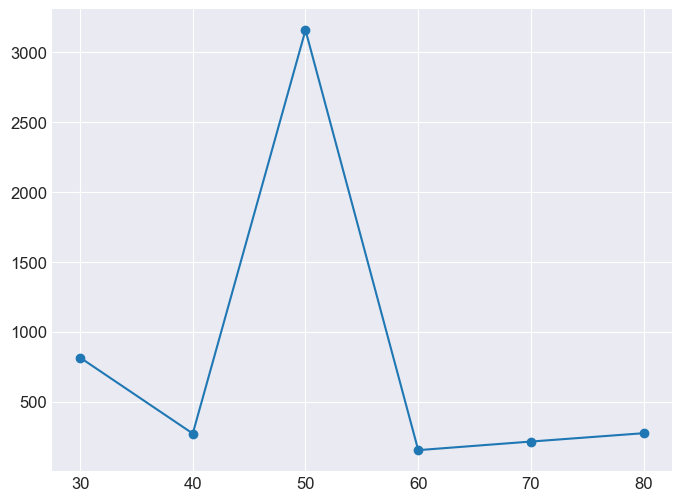

In [14]:
time = [i for i in range(30,840,10)]
plt.figure(figsize=(8,6))
plt.plot(time, MBLL_SO2['error_SO2_20_10'], 'o-', label='fit error 20mm-10mm')
a = MBLL_SO2['error_SO2_20_10'].copy()
a.sort()
plt.ylim((0, a[-20]))
plt.ylabel('RMSPE(%)')
plt.xlabel('time [sec]')
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result',  exp, 'MBLL', f'fitting_RMSPE_result.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

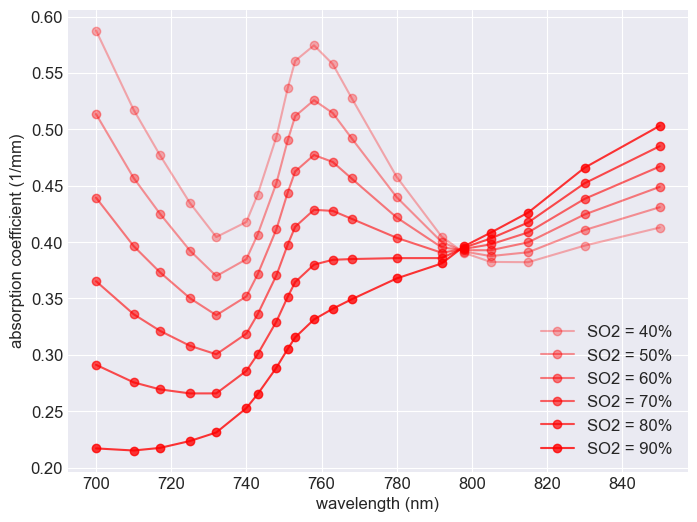

In [15]:
plt.rcParams.update({'font.size': 12})

blood_spec = pd.read_csv(os.path.join('OPs_used', 'ijv_mua_bloodConc_138.csv'))
used_SO2 = blood_spec['SO2'].to_numpy()
blood_spec = blood_spec.to_numpy()[:,1:]
plt.figure(figsize=(8,6))
for i in range(0,blood_spec.shape[0],10):
    plt.plot(wavelength, blood_spec[i], 'ro-', alpha=(i/(2*blood_spec.shape[0])+0.3),label=f'SO2 = {used_SO2[i]*100:2.0f}%')
plt.xlabel('wavelength (nm)')
plt.ylabel('absorption coefficient (1/mm)')
plt.legend()
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, f'blood_absorption.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

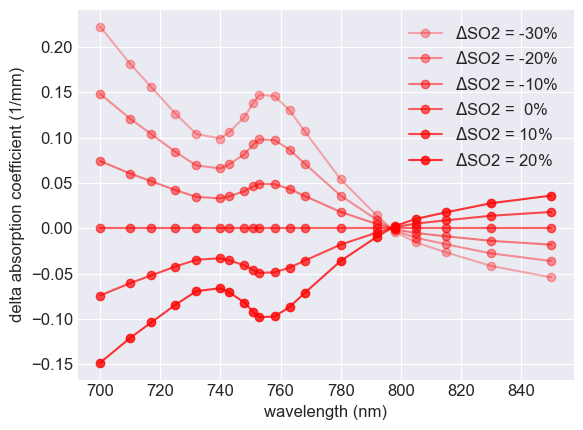

In [ ]:
for i in range(0,blood_spec.shape[0],10):
    plt.plot(wavelength, blood_spec[i] - blood_spec[30], 'ro-', alpha=(i/(2*blood_spec.shape[0])+0.3),label=f'$\Delta$SO2 = {(used_SO2[i]-0.7)*100:2.0f}%')
plt.xlabel('wavelength (nm)')
plt.ylabel('delta absorption coefficient (1/mm)')
plt.legend()
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, f'blood_delta_absorption.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.rcParams.update({'font.size': 20})

In [ ]:
import cv2 
import os
import random
from glob import glob

img = cv2.imread(os.path.join('pic', subject, f'{date}_invivo_result',  exp, 'MBLL', 'MBLL_30s.png'))
fps = 3
size = (img.shape[1], img.shape[0]) # 寬 和 高
print(size)
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #影片編碼格式
videoWrite = cv2.VideoWriter(os.path.join('pic', subject, f'{date}_invivo_result', exp,  'MBLL', 'video.mp4'), fourcc, fps, size)

files = glob(os.path.join('pic', subject, f'{date}_invivo_result',  exp, 'MBLL', "MBLL_*.png"))
files = sorted(files, key=lambda x: int(x.split('.')[-2].split('_')[-1].split('s')[-2]))
# images = [img for img in os.listdir(os.path.join('pic', subject, f'{date}_invivo_result',  'MBLL')) if img.endswith(".png")]
out_num = len(files)
for i in range(0, out_num, 1):
    fileName = files[i]
    img = cv2.imread(fileName)
    img = cv2.resize(img, size, interpolation = cv2.INTER_AREA)
    videoWrite.write(img)
videoWrite.release()

(4416, 2231)


KeyboardInterrupt: 

## Calibrate short & long

In [6]:
# cali short ch.
cali = pd.read_csv(os.path.join('dataset', subject, 'calibration_result', date, 'calibrate_SDS_1.csv'))
cali = cali.to_numpy()
cali_used_wl_data = (used_wl_data*cali[0] + cali[1])

# cali long ch.
cali2 = pd.read_csv(os.path.join('dataset', subject, 'calibration_result', date, 'calibrate_SDS_2.csv'))
cali2 = cali2.to_numpy()
cali_used_wl_data2 = (used_wl_data2*cali2[0] + cali2[1])


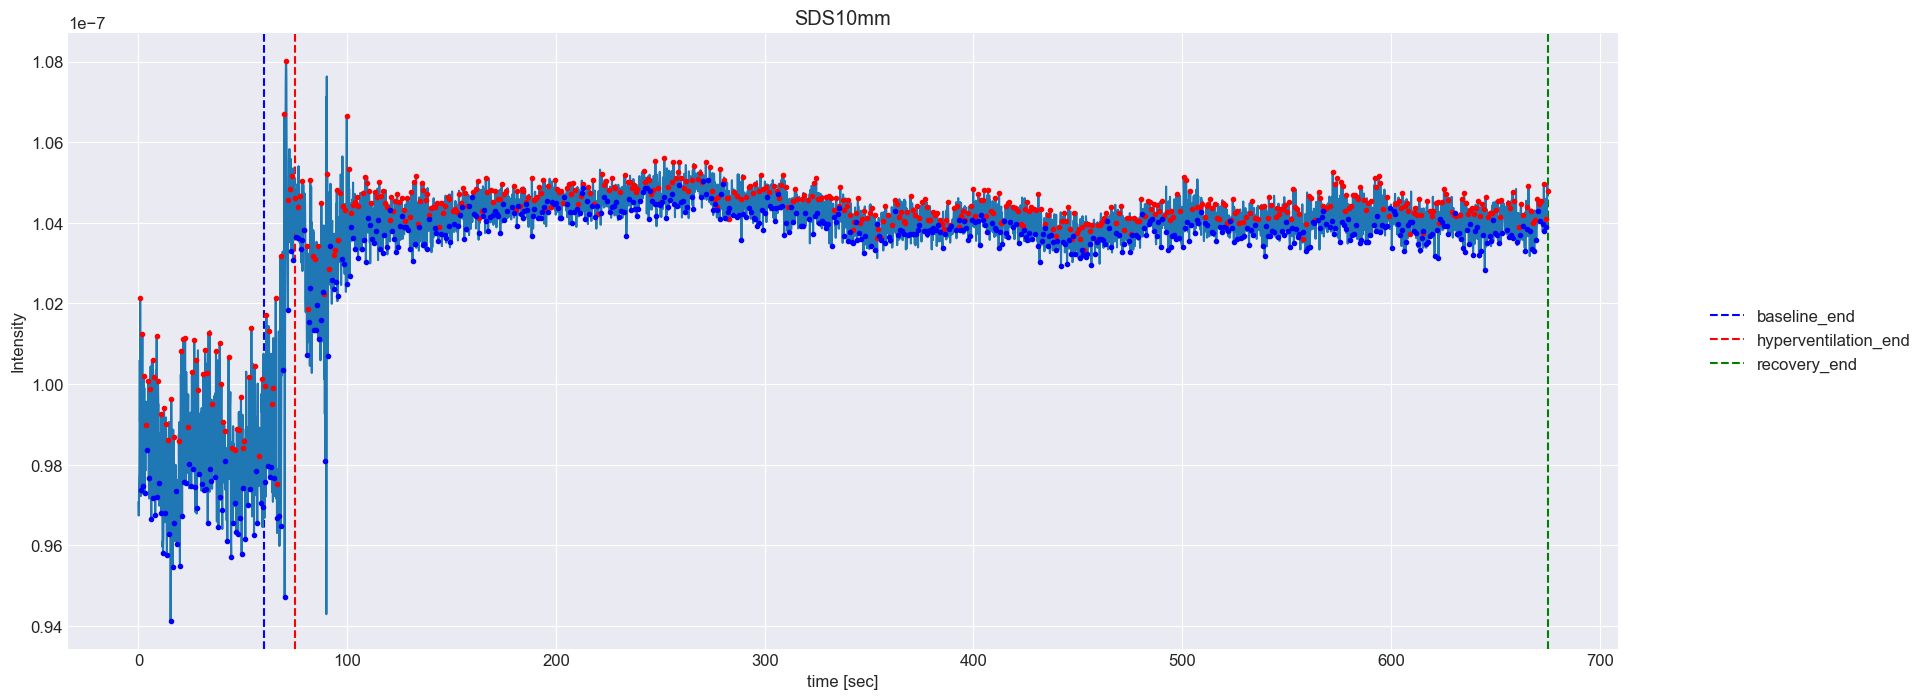

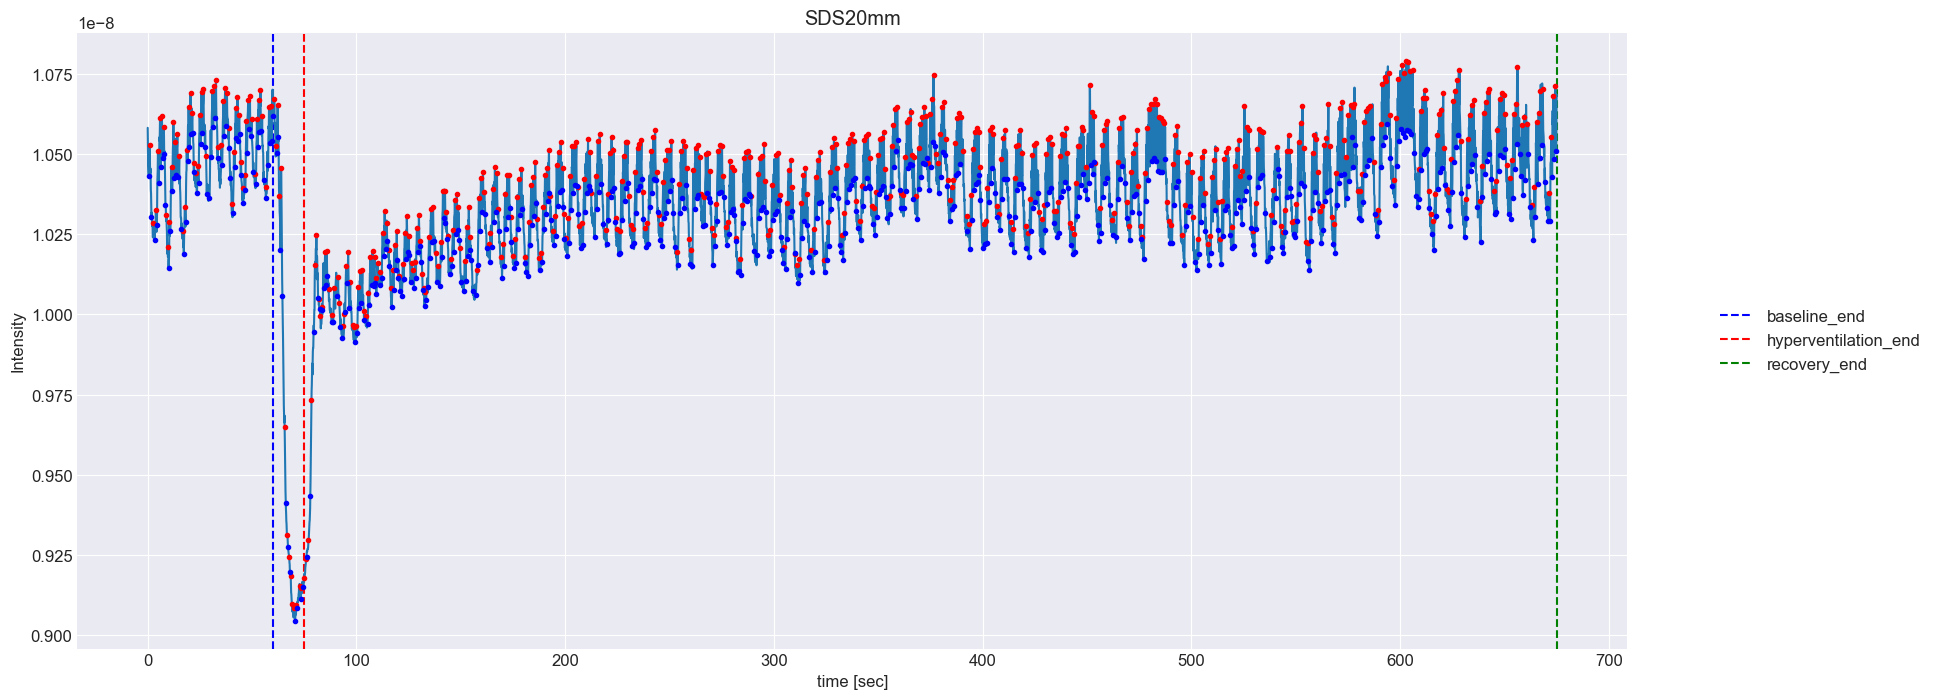

In [17]:
# plot calibrated data
plt.figure(figsize=(20,8))
time = np.linspace(0,recovery_end, cali_used_wl_data.shape[0])
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.plot(time, cali_used_wl_data.mean(1))
plt.plot(time[max_id1], cali_used_wl_data.mean(1)[max_id1], 'r.')
plt.plot(time[min_id1], cali_used_wl_data.mean(1)[min_id1], 'b.')
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS10mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'cali_SDS1.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,8))
time = np.linspace(0,recovery_end, cali_used_wl_data2.shape[0])
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.plot(time, cali_used_wl_data2.mean(1))
plt.plot(time[max_id2], cali_used_wl_data2.mean(1)[max_id2], 'r.')
plt.plot(time[min_id2], cali_used_wl_data2.mean(1)[min_id2], 'b.')
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS20mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'cali_SDS2.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

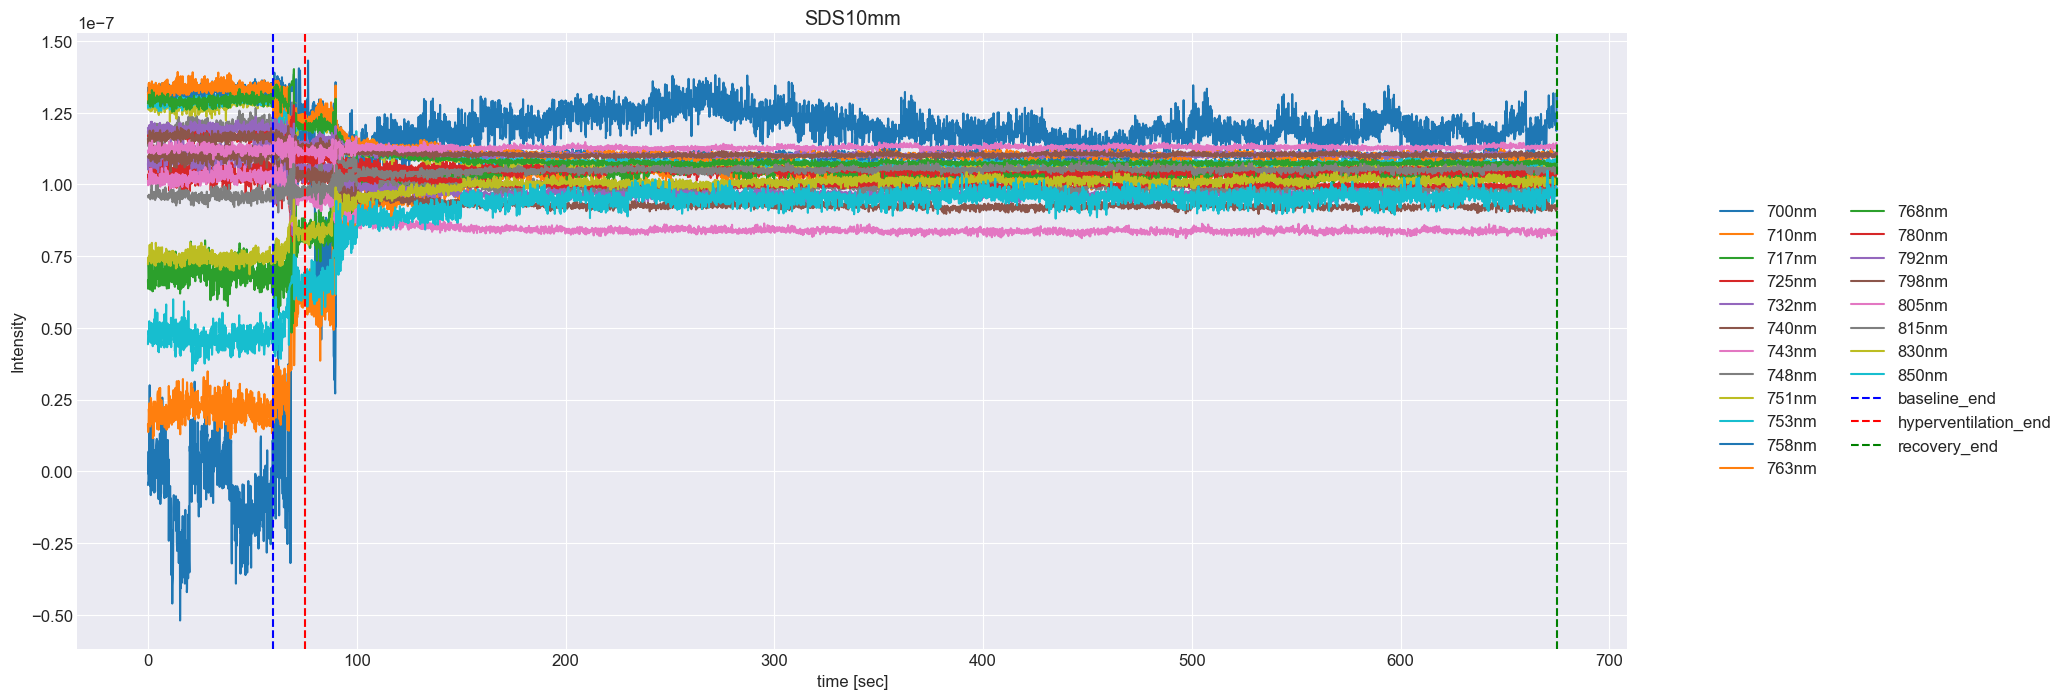

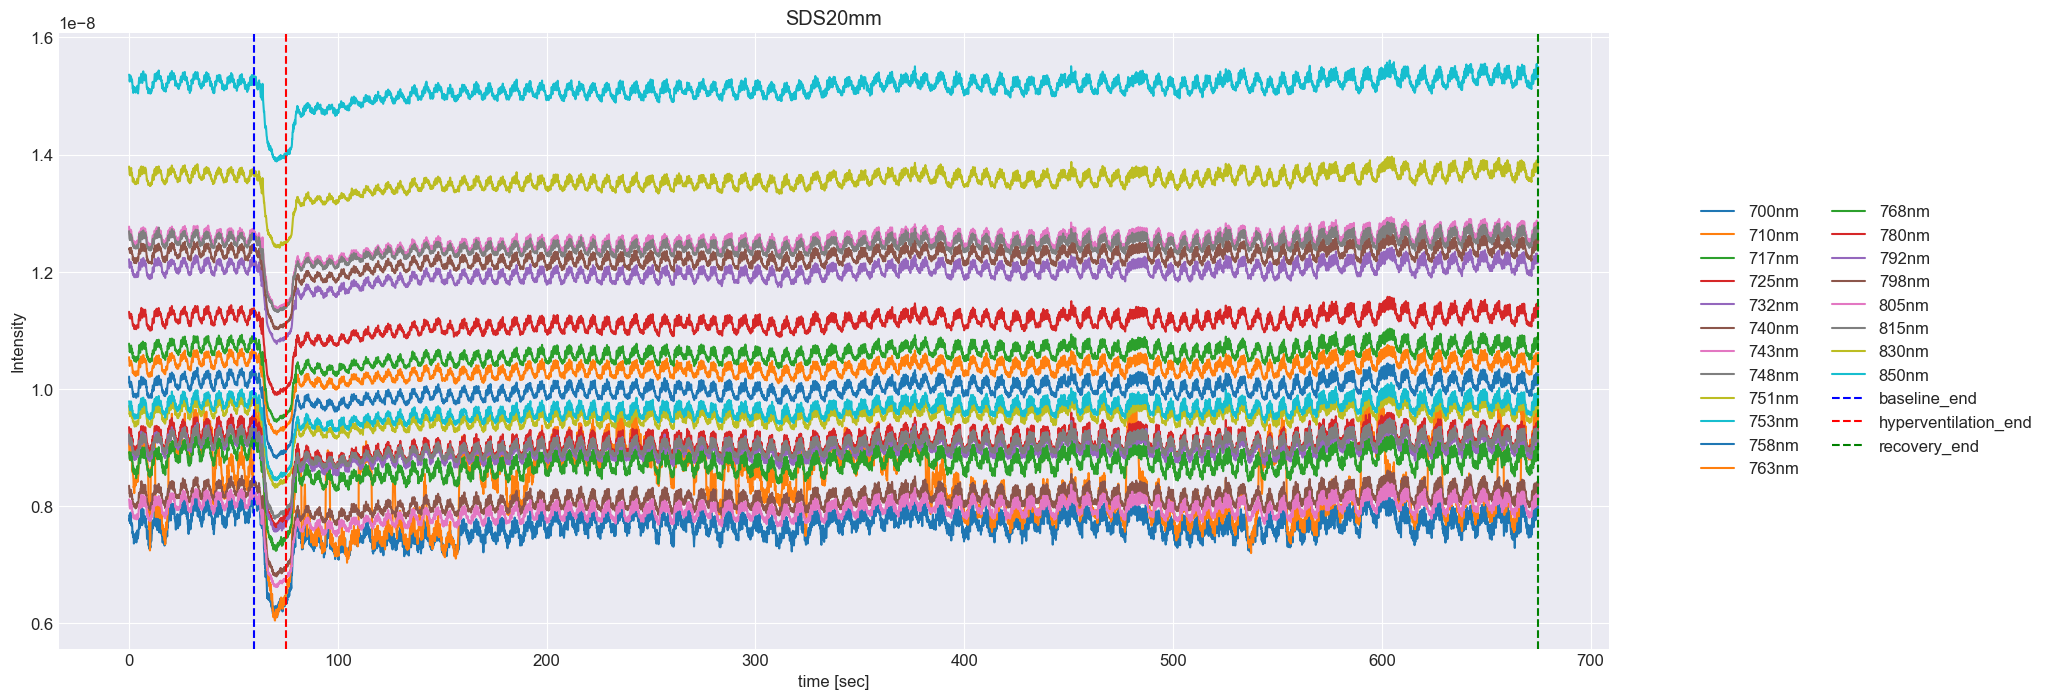

In [18]:
# plot all the wavelength
plt.figure(figsize=(20,8))
time = [i*SDS1_time_resolution for i in range(cali_used_wl_data.shape[0])]
for i in range(20):
    plt.plot(time, cali_used_wl_data[:,i], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True, ncol=2)
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS10mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'cali_each_wl_SDS1.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,8))
time = [i*SDS2_time_resolution for i in range(cali_used_wl_data2.shape[0])]
for i in range(20):
    plt.plot(time,cali_used_wl_data2[:,i], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True, ncol=2)
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS20mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'cali_each_wl_SDS2.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

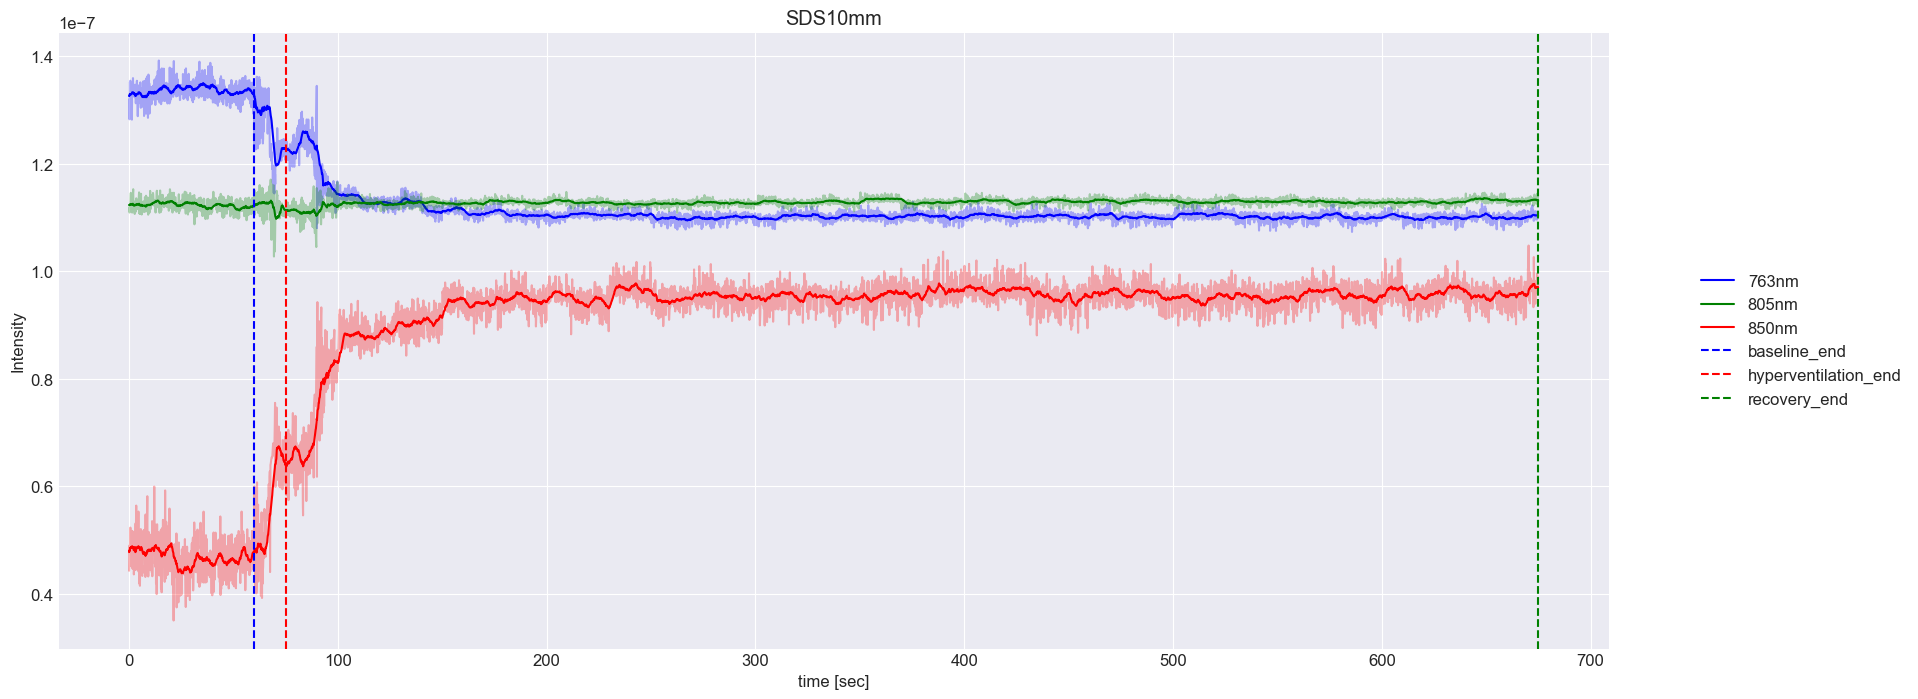

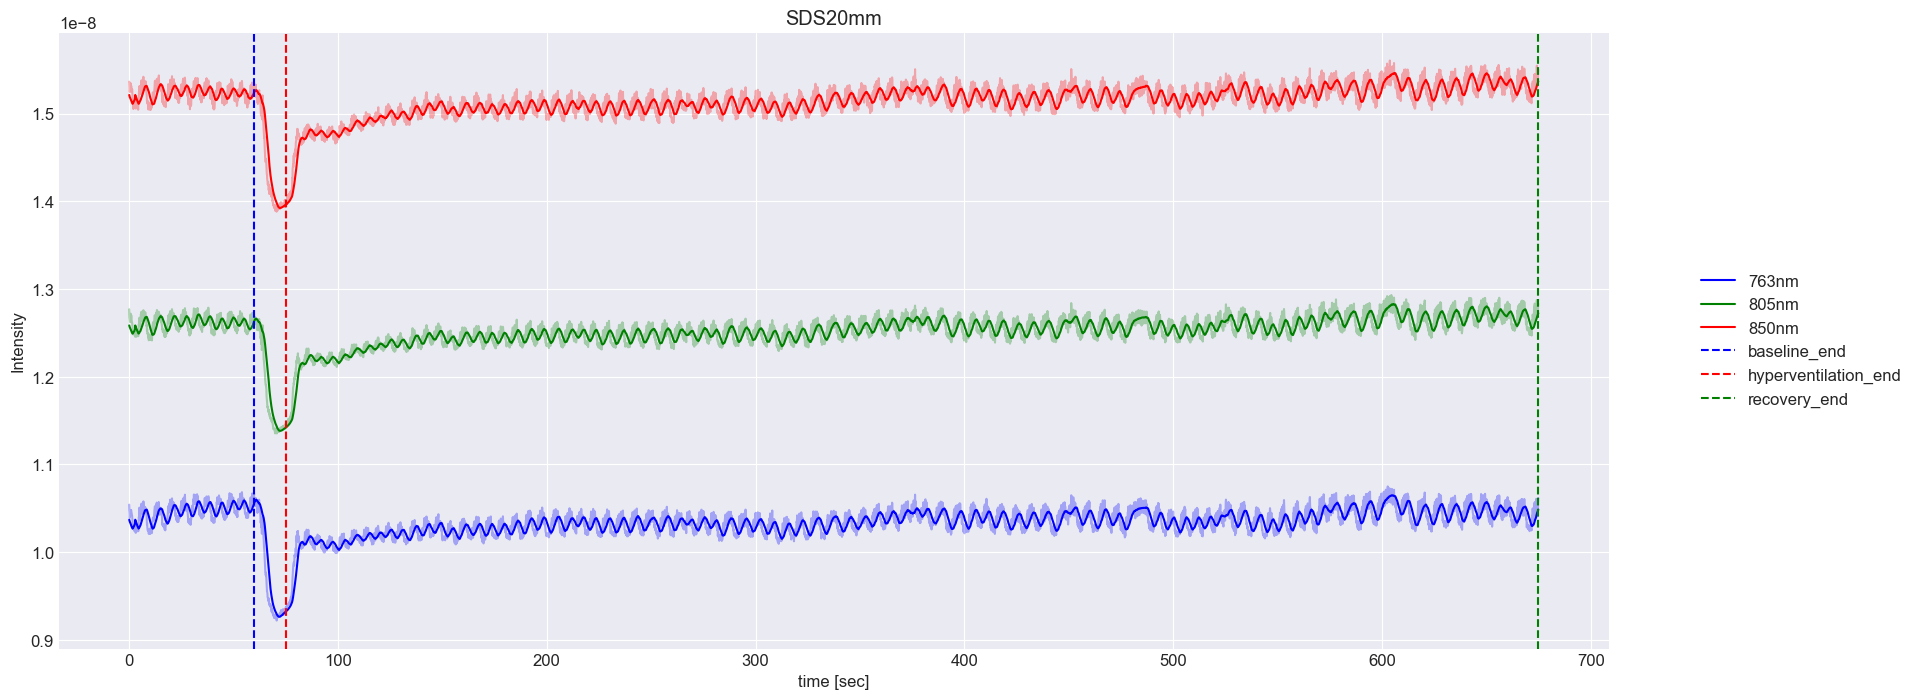

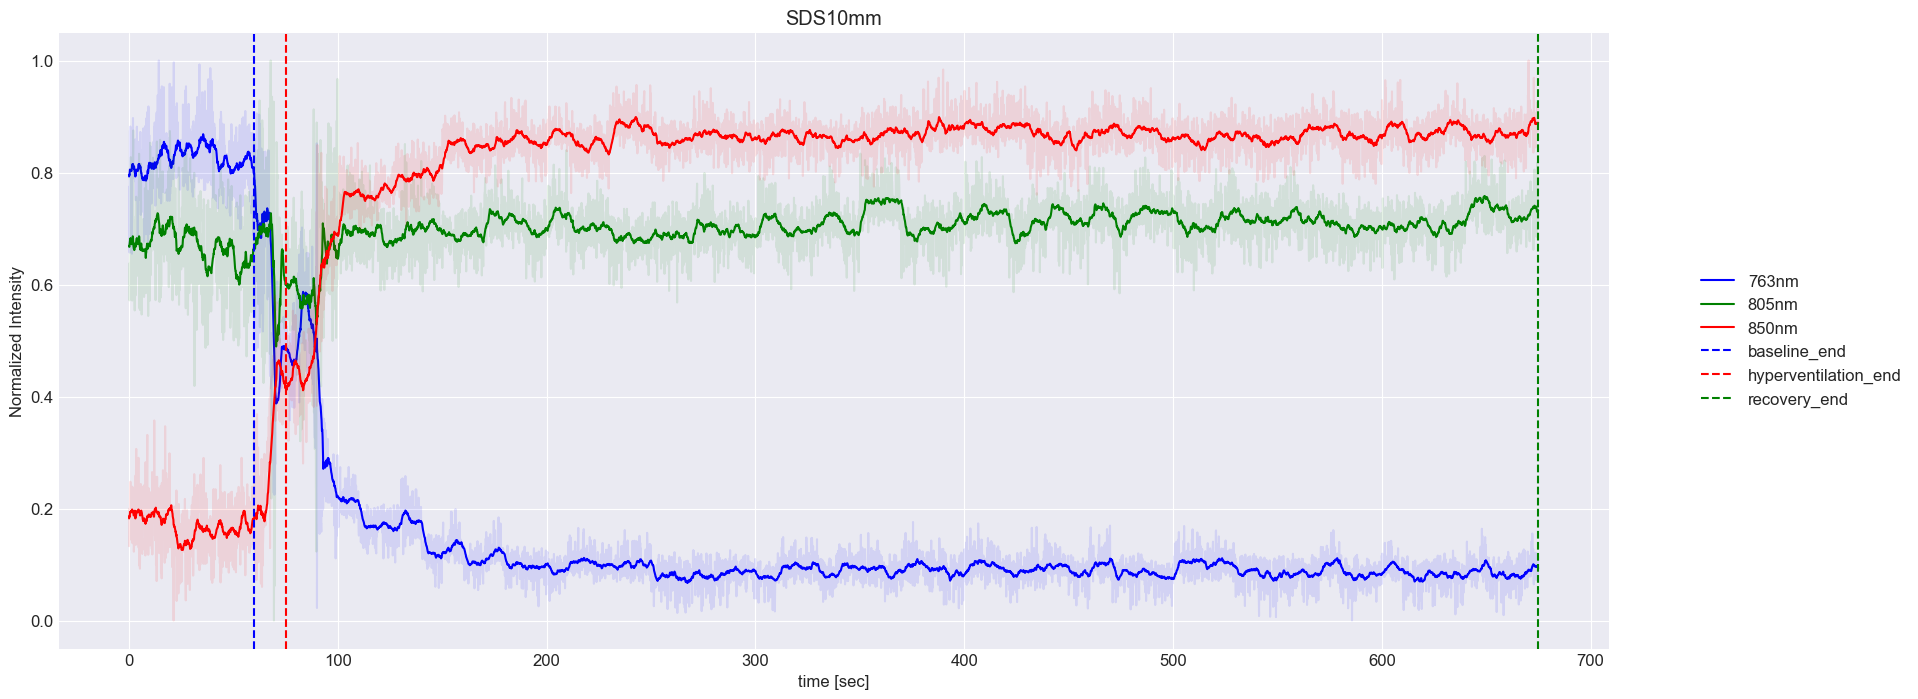

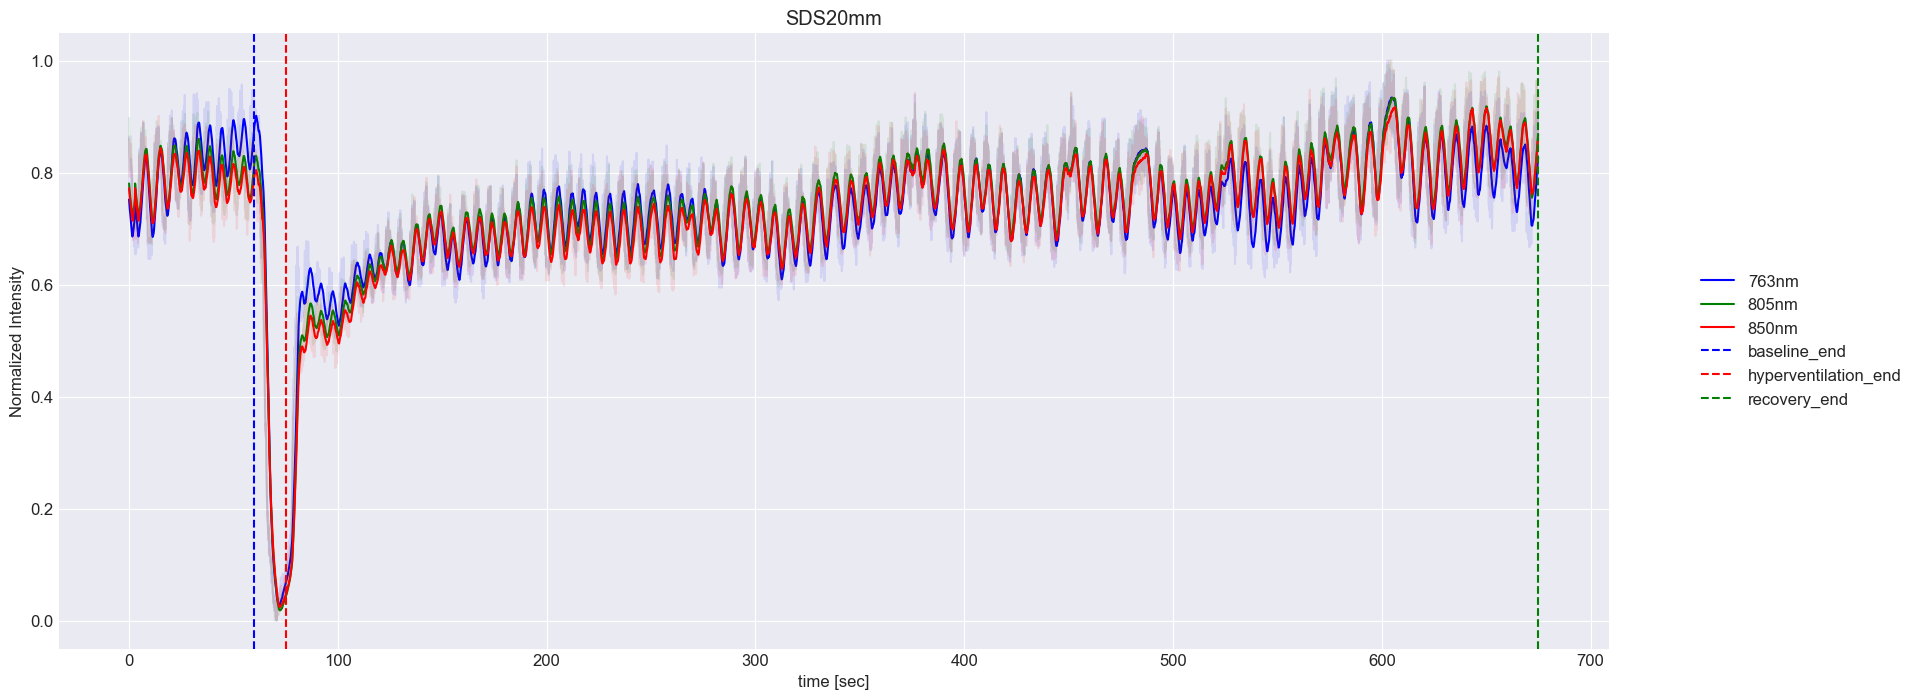

In [19]:
# plot interested wavelength [763nm , 805nm, 850nm]
plt.figure(figsize=(20,8))
time = [i*SDS1_time_resolution for i in range(cali_used_wl_data.shape[0])]
color = ['blue', 'green', 'red']
for c_idx, i in enumerate([np.where(wavelength==763)[0][0], np.where(wavelength==805)[0][0], np.where(wavelength==850)[0][0]]):
    BF_used_wl_data, AF_used_wl_data = before_after_moving_average(data=cali_used_wl_data[:,i])
    plt.plot(time, BF_used_wl_data, color=color[c_idx], alpha=0.3)
    plt.plot(time, AF_used_wl_data, color=color[c_idx], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS10mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'cali_focus_wl_SDS1.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,8))
time = [i*SDS2_time_resolution for i in range(cali_used_wl_data2.shape[0])]
color = ['blue', 'green', 'red']
for c_idx, i in enumerate([np.where(wavelength==763)[0][0], np.where(wavelength==805)[0][0], np.where(wavelength==850)[0][0]]):
    BF_used_wl_data, AF_used_wl_data = before_after_moving_average(data=cali_used_wl_data2[:,i])
    plt.plot(time, BF_used_wl_data, color=color[c_idx], alpha=0.3)
    plt.plot(time, AF_used_wl_data, color=color[c_idx], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.xlabel('time [sec]')
plt.ylabel('Intensity')
plt.title('SDS20mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'cali_focus_wl_SDS2.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()



plt.figure(figsize=(20,8))
time = [i*SDS1_time_resolution for i in range(cali_used_wl_data.shape[0])]
color = ['blue', 'green', 'red']
for c_idx, i in enumerate([np.where(wavelength==763)[0][0], np.where(wavelength==805)[0][0], np.where(wavelength==850)[0][0]]):
    BF_used_wl_data, AF_used_wl_data = before_after_moving_average(data=cali_used_wl_data[:,i])
    plt.plot(time, (BF_used_wl_data- BF_used_wl_data.min())/(BF_used_wl_data.max()-BF_used_wl_data.min()), color=color[c_idx], alpha=0.1)
    plt.plot(time, (AF_used_wl_data- BF_used_wl_data.min())/(BF_used_wl_data.max()-BF_used_wl_data.min()), color=color[c_idx], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.xlabel('time [sec]')
plt.ylabel('Normalized Intensity')
plt.title('SDS10mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'cali_normalized_focus_wl_SDS1.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,8))
time = [i*SDS2_time_resolution for i in range(cali_used_wl_data2.shape[0])]
color = ['blue', 'green', 'red']
for c_idx, i in enumerate([np.where(wavelength==763)[0][0], np.where(wavelength==805)[0][0], np.where(wavelength==850)[0][0]]):
    BF_used_wl_data, AF_used_wl_data = before_after_moving_average(data=cali_used_wl_data2[:,i])
    plt.plot(time, (BF_used_wl_data- BF_used_wl_data.min())/(BF_used_wl_data.max()-BF_used_wl_data.min()), color=color[c_idx], alpha=0.1)
    plt.plot(time, (AF_used_wl_data- BF_used_wl_data.min())/(BF_used_wl_data.max()-BF_used_wl_data.min()), color=color[c_idx], label=f'{wavelength[i]}nm')

plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.xlabel('time [sec]')
plt.ylabel('Normalized Intensity')
plt.title('SDS20mm')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'cali_normalized_focus_wl_SDS2.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()


## Plot Rmax/Rmin

In [20]:
SDS1_Rmax_Rmin_data = []
SDS2_Rmax_Rmin_data = []
for ts in range(0, recovery_end, 10):
    td = ts + 10
    used_max_idx1 = np.where(((max_id1<round(td/SDS1_time_resolution))&(max_id1>=round(ts/SDS1_time_resolution))))
    used_min_idx1 = np.where(((min_id1<round(td/SDS1_time_resolution))&(min_id1>=round(ts/SDS1_time_resolution))))
    SDS1_Rmax_Rmin_data += [used_wl_data[max_id1[used_max_idx1]].mean() / used_wl_data[min_id1[used_min_idx1]].mean()]
    
    used_max_idx2 = np.where(((max_id2<round(td/SDS1_time_resolution))&(max_id2>=round(ts/SDS1_time_resolution))))
    used_min_idx2 = np.where(((min_id2<round(td/SDS1_time_resolution))&(min_id2>=round(ts/SDS1_time_resolution))))
    SDS2_Rmax_Rmin_data += [used_wl_data2[max_id2[used_max_idx2]].mean() / used_wl_data2[min_id2[used_min_idx2]].mean()]

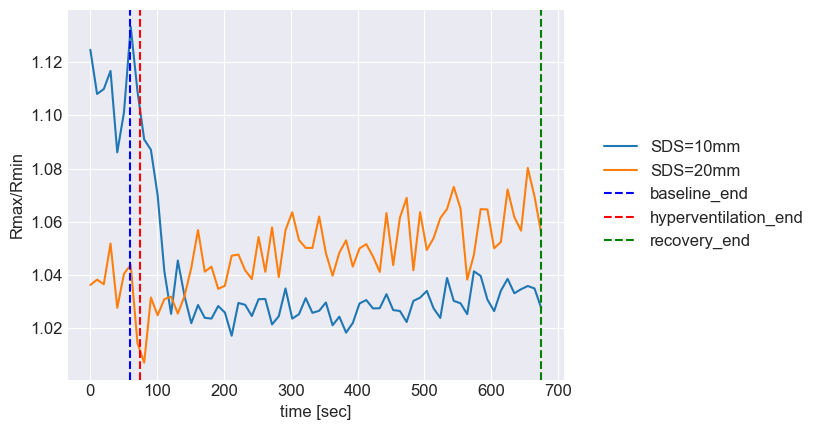

In [21]:
plt.rcParams.update({'font.size': 12})
time = np.linspace(0, recovery_end, len(SDS1_Rmax_Rmin_data))
plt.plot(time, SDS1_Rmax_Rmin_data, label='SDS=10mm')
plt.plot(time, SDS2_Rmax_Rmin_data, label='SDS=20mm')
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=recovery_end, linestyle='--', color='g', label='recovery_end')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.xlabel('time [sec]')
plt.ylabel('Rmax/Rmin')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp,'Rmax_Rmin.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

## Predict in-vivo data

In [7]:
plt.rcParams.update({'font.size': 12})

In [8]:
# load model 
import torch
from ANN_models import PredictionModel, PredictionModel2, PredictionModel3, PredictionModel4, PredictionModel5, PredictionModel6
with open(os.path.join("model_save", "prediction_model_formula24", subject, "trlog.json"), 'r') as f:
    trlog = json.load(f)
    best_model = trlog['best_model']
model = PredictionModel5(neuronsize=5).cuda()
model.load_state_dict(torch.load(best_model))

<All keys matched successfully>

In [9]:
def get_OD(used_wl_data, used_wl_data2, time, average_time=6):
    time_resolution = SDS1_time_resolution
    time_resolution2 = SDS2_time_resolution
    sds1_ijv_small = used_wl_data[max_id1[np.where(abs(max_id1-round(time/time_resolution))<round(average_time/time_resolution))]].mean(0)
    sds1_ijv_large = used_wl_data[min_id1[np.where(abs(min_id1-round(time/time_resolution))<round(average_time/time_resolution))]].mean(0)
    
    sds2_ijv_small = used_wl_data2[max_id2[np.where(abs(max_id2-round(time/time_resolution2))<round(average_time/time_resolution2))]].mean(0)
    sds2_ijv_large = used_wl_data2[min_id2[np.where(abs(min_id2-round(time/time_resolution2))<round(average_time/time_resolution2))]].mean(0)
    
    # sds1_ijv_small = used_wl_data[max_id[idx:idx+average_point]].mean(0)
    # sds1_ijv_large = used_wl_data[min_id[idx:idx+average_point]].mean(0)

    # sds2_ijv_small = used_wl_data2[max_id2[idx:idx+average_point]].mean(0)
    # sds2_ijv_large = used_wl_data2[min_id2[idx:idx+average_point]].mean(0)
    OD_spec = []

    # for sds2_large in sds2_ijv_large:
    #     for sds1_large in sds1_ijv_large:
    #         OD_spec += [sds1_large/sds2_large]

    # for sds2_small in sds2_ijv_small:
    #     for sds1_small in sds1_ijv_small:
    #         OD_spec += [sds1_small/sds2_small]
    for sds1_large in sds1_ijv_large:
        for sds2_large in sds2_ijv_large:
            OD_spec += [sds2_large/sds1_large]
            
    for sds1_small in sds1_ijv_small:
        for sds2_small in sds2_ijv_small:
            OD_spec += [sds2_small/sds1_small]

    
    return np.array(OD_spec)

In [10]:

total_predict = []
using_time = []
for idx, time in enumerate(range(10,recovery_end-50,10)):
    using_time += [time]
    OD1_spec = get_OD(used_wl_data=cali_used_wl_data, 
                      used_wl_data2=cali_used_wl_data2, 
                      time=time,
                      average_time=6)
    
    OD2_spec = get_OD(used_wl_data=cali_used_wl_data, 
                      used_wl_data2=cali_used_wl_data2, 
                      time=time+10,
                      average_time=6)
    if idx == 0:
        result_OD1_spec = OD1_spec.reshape(1,-1)
        result_OD2_spec = OD2_spec.reshape(1,-1)
    else:
        result_OD1_spec = np.concatenate((result_OD1_spec, OD1_spec.reshape(1,-1)))
        result_OD2_spec = np.concatenate((result_OD2_spec, OD2_spec.reshape(1,-1)))
        
    
    # # # normalize 
    # for i in range(40):
    #     OD1_spec[i*20:i*20+20] = (OD1_spec[i*20:i*20+20] - OD1_spec[i*20:i*20+20].mean()) / (OD1_spec[i*20:i*20+20].max() - OD1_spec[i*20:i*20+20].min())
    
    # for i in range(40):
    #     OD2_spec[i*20:i*20+20] = (OD2_spec[i*20:i*20+20] - OD2_spec[i*20:i*20+20].mean()) / (OD2_spec[i*20:i*20+20].max() - OD2_spec[i*20:i*20+20].min())
        
    # delta_OD = OD2_spec - OD1_spec
    delta_OD = OD1_spec/OD2_spec
    
    # # normalize 
    # for i in range(40):
    #     delta_OD[i*20:i*20+20] = (delta_OD[i*20:i*20+20] - delta_OD[i*20:i*20+20].mean()) / (delta_OD[i*20:i*20+20].max() - delta_OD[i*20:i*20+20].min())
    
    # normalize 
    for i in range(40):
        delta_OD[i*20:i*20+20] = (delta_OD[i*20:i*20+20] - delta_OD[i*20:i*20+20].min() + 1e-9) / (delta_OD[i*20:i*20+20].max() - delta_OD[i*20:i*20+20].min() + 1e-9)
    delta_OD = np.log(delta_OD)
    
    
    
    
    model_input = torch.tensor(delta_OD)
    model_input = model_input.to(torch.float32).cuda()
    predict = model(model_input)
    total_predict += [predict.item()]
total_predict = np.array(total_predict)*100

## fix nan value
for nan_idx in np.argwhere(np.isnan(total_predict)):
    
    prev_idx = nan_idx-1
    while np.isnan(total_predict[prev_idx]):
        prev_idx = prev_idx - 1

    next_idx = nan_idx+1
    while np.isnan(total_predict[next_idx]):
        next_idx = next_idx + 1
    
    total_predict[nan_idx] = (total_predict[prev_idx] +  total_predict[next_idx])/2

## save result
save_result = pd.DataFrame({'time [sec]' : using_time, 
              'predict_result' : total_predict.tolist()})
save_result.to_csv(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'each_predict_result.csv'), index=False)
total_predict

array([ 24.53108281,  -8.57851058,   7.26404488,   8.4195748 ,
        -6.64985254, -60.03581882,   9.10969973,   5.75581044,
        -0.27230084,   4.85174358,   0.50482824, -24.06681925,
        21.47475034,  11.96319908,   3.61428559,   5.33672124,
         4.21024561,   9.13827866,   6.46792352,  20.77490538,
         9.95377451,  -0.76072216,   6.27360791,  10.52872539,
        14.38611001, -22.05187678, -21.01626396,   5.03113717,
       -18.5854882 , -26.85339451,  11.70798093,   4.78378981,
         6.07749969, -36.78811193,  10.64918935,  11.95651442,
       -40.61893225, -42.46386886,   9.25014466, -38.65004182,
        10.13460755,  -7.14831054,   9.293966  ,   6.18876666,
       -20.03290057, -37.89363503,   4.59891856, -51.07743144,
       -31.08494878,  -3.70794088,   3.58596593,  14.08306062,
        -4.13230211,   6.50528073,  18.56849045,   8.13537985,
         9.75320637,   3.90641391,   8.90877098, -43.59393716,
        -0.81972033,  13.85016888])

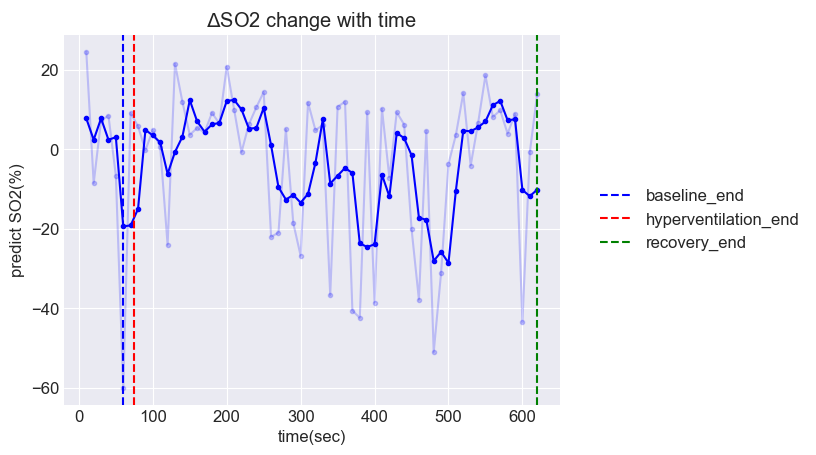

In [13]:
BF_total_predict, AF_total_predict = before_after_moving_average(data=total_predict, avg_points=3)

plt.plot(using_time, AF_total_predict, "b.-")
plt.plot(using_time, BF_total_predict, "b.-", alpha=0.2)
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=using_time[-1], linestyle='--', color='g', label='recovery_end')
plt.xlabel("time(sec)")
plt.ylabel("predict SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.title(f'$\Delta$SO2 change with time')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'predict_change_with_time.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

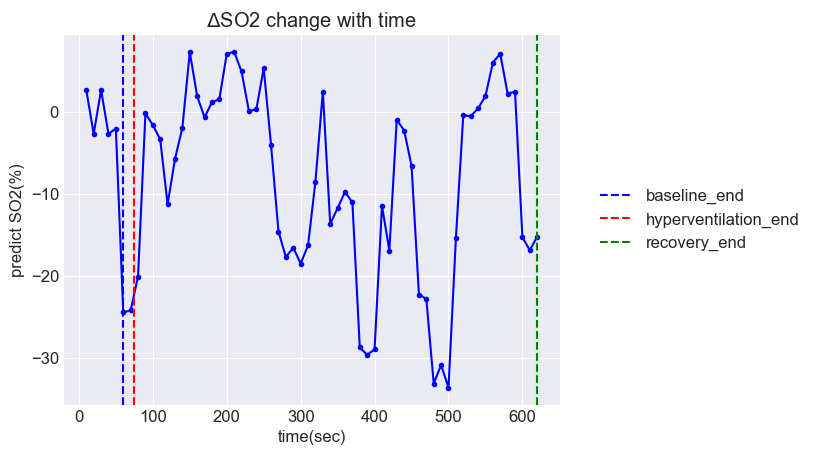

In [14]:
# shift baseline
AF_total_predict = (AF_total_predict - AF_total_predict[:4].mean())

plt.plot(using_time, AF_total_predict, "b.-")
plt.plot(using_time, BF_total_predict, "b.-", alpha=0.2)
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=using_time[-1], linestyle='--', color='g', label='recovery_end')
plt.xlabel("time(sec)")
plt.ylabel("predict SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.title(f'$\Delta$SO2 change with time')
plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'predict_change_with_time_shift.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

In [15]:
total_predict = []
using_time = []
# baseline_time = [i for i in range(0,50,10)]
# HP_time = [i for i in range(70,230,10)]
# recovery_time = [i for i in range(250,420,10)]
# total_time = baseline_time + HP_time + recovery_time
for idx, time in enumerate(range(10,recovery_end-50,10)):
    using_time += [time]
    OD1_spec = get_OD(used_wl_data=cali_used_wl_data, 
                      used_wl_data2=cali_used_wl_data2, 
                      time=0, average_time=30)
    
    OD2_spec = get_OD(used_wl_data=cali_used_wl_data, 
                      used_wl_data2=cali_used_wl_data2, 
                      time=time, average_time=6)
    if idx == 0:
        result_OD1_spec = OD1_spec.reshape(1,-1)
        result_OD2_spec = OD2_spec.reshape(1,-1)
    else:
        result_OD1_spec = np.concatenate((result_OD1_spec, OD1_spec.reshape(1,-1)))
        result_OD2_spec = np.concatenate((result_OD2_spec, OD2_spec.reshape(1,-1)))
        
    
    # # # normalize 
    # for i in range(40):
    #     OD1_spec[i*20:i*20+20] = (OD1_spec[i*20:i*20+20] - OD1_spec[i*20:i*20+20].mean()) / (OD1_spec[i*20:i*20+20].max() - OD1_spec[i*20:i*20+20].min())
    
    # for i in range(40):
    #     OD2_spec[i*20:i*20+20] = (OD2_spec[i*20:i*20+20] - OD2_spec[i*20:i*20+20].mean()) / (OD2_spec[i*20:i*20+20].max() - OD2_spec[i*20:i*20+20].min())
    
    # delta_OD = OD2_spec - OD1_spec
 
    delta_OD = OD1_spec/OD2_spec
    
    # # normalize 
    # for i in range(40):
    #     delta_OD[i*20:i*20+20] = (delta_OD[i*20:i*20+20] - delta_OD[i*20:i*20+20].mean()) / (delta_OD[i*20:i*20+20].max() - delta_OD[i*20:i*20+20].min())
    
    # normalize 
    for i in range(40):
        delta_OD[i*20:i*20+20] = (delta_OD[i*20:i*20+20] - delta_OD[i*20:i*20+20].min() + 1e-9) / (delta_OD[i*20:i*20+20].max() - delta_OD[i*20:i*20+20].min() + 1e-9)
    delta_OD = np.log(delta_OD)
    
    
    model_input = torch.tensor(delta_OD)
    model_input = model_input.to(torch.float32).cuda()
    predict = model(model_input)
    total_predict += [predict.item()]
total_predict = np.array(total_predict)*100

## fix nan value
for nan_idx in np.argwhere(np.isnan(total_predict)):
    
    prev_idx = nan_idx-1
    while np.isnan(total_predict[prev_idx]):
        prev_idx = prev_idx - 1

    next_idx = nan_idx+1
    while np.isnan(total_predict[next_idx]):
        next_idx = next_idx + 1
    
    total_predict[nan_idx] = (total_predict[prev_idx] +  total_predict[next_idx])/2


save_result = pd.DataFrame({'time [sec]' : using_time, 
              'predict_result' : total_predict.tolist()})
# save_result.to_csv(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'cum_predict_result.csv'), index=False)
total_predict

array([-26.77738667,  13.4188056 ,   7.83561319,  28.7181139 ,
        20.85053176,  19.95195299, -59.68509316, -48.19259644,
       -45.19850016, -48.3774662 , -45.26547194, -45.40652633,
       -45.49898505, -50.33445954, -51.59769654, -37.98827529,
        -7.38097429, -37.03697324, -14.41406608,  -2.10883841,
         7.83847421,   8.87558609,   6.72673434,   4.12131697,
        10.18086821,  11.13224626,  11.96017563,   3.68358344,
         7.24709779,  -4.27937657, -37.90470958, -20.19309253,
       -24.19120818,   6.32759631,   7.16629028,   5.13046831,
         6.14533722,  21.36383504,   7.30806291,  18.87209862,
         7.21781999,   3.56833339,   4.534702  ,   3.12797278,
        11.13709658,   9.514229  ,  19.99760419,  32.07857609,
         5.69496006, -24.02370572, -24.65475053,  -0.74314028,
        13.58949393, -41.23163223,  -1.7052561 , -20.03953755,
        30.07824421,  21.32330984,  31.71640038,  15.40864557,
        16.7344138 ,  16.85555428])

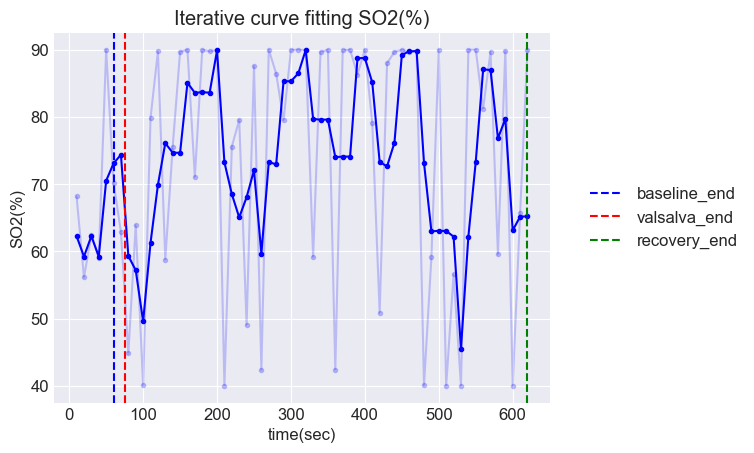

In [16]:
fitting_SO2 = np.load(os.path.join('pic', subject, f'{date}_invivo_result', exp, "fitting", "SDS2", "fit_result_OPs", "chromophore", f"fitting_SO2.npy"))
fitting_SO2 = fitting_SO2[:62]*100
BF_fitting_SO2, AF_fitting_SO2 = before_after_moving_average(data=fitting_SO2, avg_points=3)

plt.plot(using_time, AF_fitting_SO2, "b.-")
plt.plot(using_time, BF_fitting_SO2, "b.-", alpha=0.2)
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='valsalva_end')
plt.axvline(x=using_time[-1], linestyle='--', color='g', label='recovery_end')
plt.xlabel("time(sec)")
plt.ylabel("SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.title(f'Iterative curve fitting SO2(%)')
# plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'predict_cumulative.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

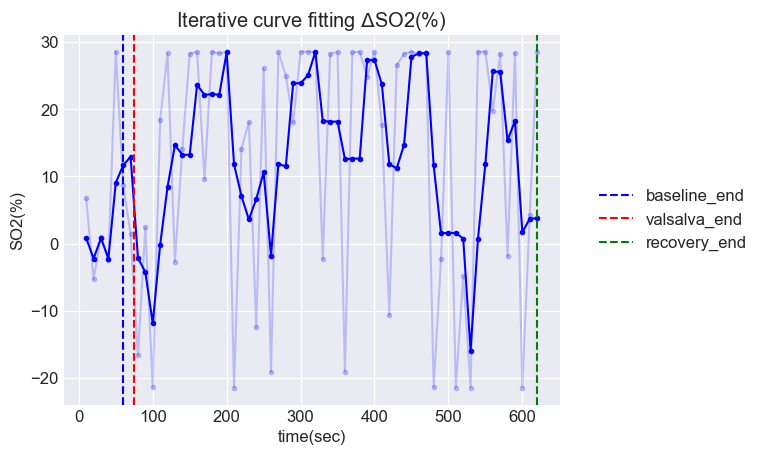

In [17]:
change_fitting_SO2 = fitting_SO2 - fitting_SO2[:4].mean()
BF_change_fitting_SO2, AF_change_fitting_SO2 = before_after_moving_average(data=change_fitting_SO2, avg_points=3)

plt.plot(using_time, AF_change_fitting_SO2, "b.-")
plt.plot(using_time, BF_change_fitting_SO2, "b.-", alpha=0.2)
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='valsalva_end')
plt.axvline(x=using_time[-1], linestyle='--', color='g', label='recovery_end')
plt.xlabel("time(sec)")
plt.ylabel("SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.title(f'Iterative curve fitting $\Delta$SO2(%)')
# plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'predict_cumulative.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()


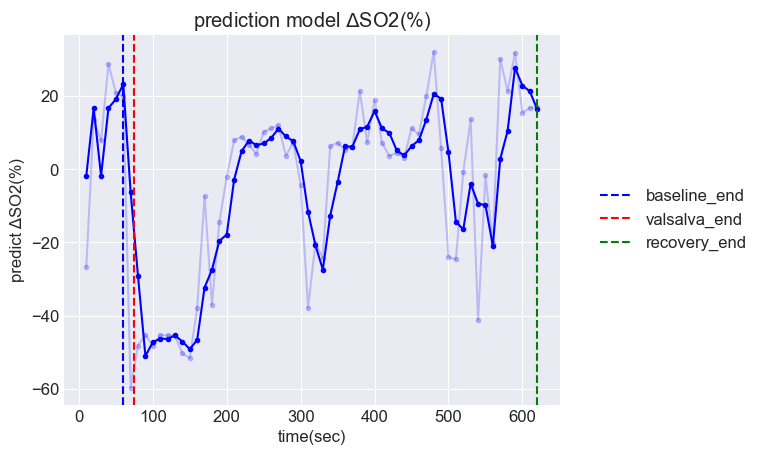

In [18]:
BF_total_predict, AF_total_predict = before_after_moving_average(data=total_predict, avg_points=3)

plt.plot(using_time, AF_total_predict, "b.-")
plt.plot(using_time, BF_total_predict, "b.-", alpha=0.2)
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='valsalva_end')
plt.axvline(x=using_time[-1], linestyle='--', color='g', label='recovery_end')
plt.xlabel("time(sec)")
plt.ylabel("predict \u0394SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.title(f'prediction model $\Delta$SO2(%)')
# plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'predict_cumulative.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

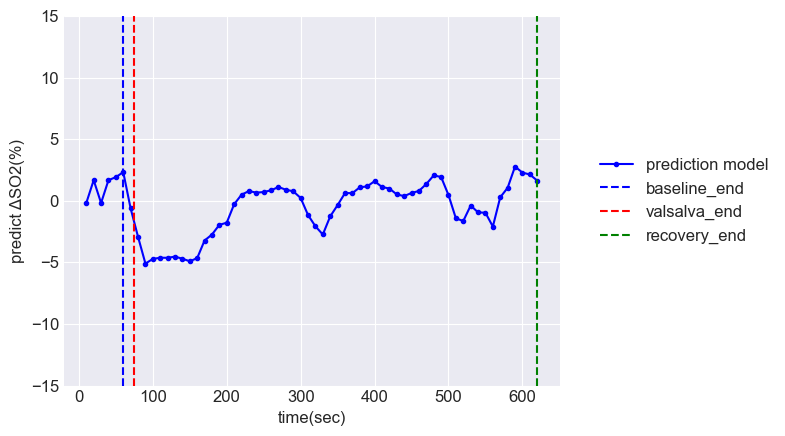

In [19]:
# shift baseline
# AF_total_predict = (AF_total_predict - AF_total_predict[:4].mean())
# AF_change_fitting_SO2 = (AF_change_fitting_SO2 - AF_change_fitting_SO2[:4].mean())

# plt.plot(using_time, AF_change_fitting_SO2, "r.-", label='curve fitting')
plt.plot(using_time, AF_total_predict*0.1, "b.-", label='prediction model')
# plt.plot(using_time, BF_total_predict, "b.-", alpha=0.2)
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='valsalva_end')
plt.axvline(x=using_time[-1], linestyle='--', color='g', label='recovery_end')
plt.xlabel("time(sec)")
plt.ylabel("predict \u0394SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
# plt.title(f'$\Delta$SO2')
plt.ylim([-15,15])
# plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', exp, 'predict_cumulative_shift.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()

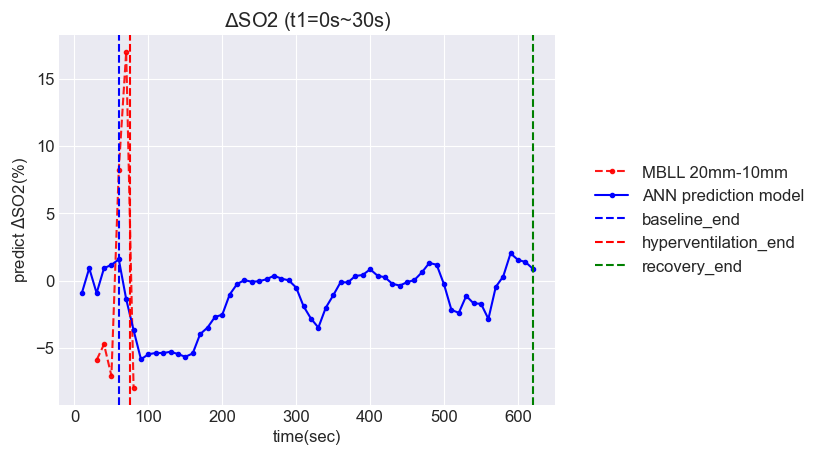

In [31]:
plt.plot(MBLL_SO2['time'], MBLL_SO2['delta_SO2_20_10'], 'r.--', alpha=0.9, label='MBLL 20mm-10mm')
# plt.plot(MBLL_SO2['time'], MBLL_SO2['delta_SO2_20_7'], 'r.--', alpha=0.6, label='MBLL 20mm-7.5mm')
# plt.plot(MBLL_SO2['time'], MBLL_SO2['delta_SO2_20_4'], 'r.--', alpha=0.3, label='MBLL 20mm-4.5mm')
plt.plot(using_time, AF_total_predict*0.1, "b.-", label='ANN prediction model')
# plt.plot(using_time, BF_total_predict, "b.-", alpha=0.2)
plt.axvline(x=baseline_end, linestyle='--', color='b', label='baseline_end')
plt.axvline(x=exp_end, linestyle='--', color='r', label='hyperventilation_end')
plt.axvline(x=using_time[-1], linestyle='--', color='g', label='recovery_end')
plt.xlabel("time(sec)")
plt.ylabel("predict $\Delta$SO2(%)")
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),
          fancybox=True, shadow=True)
plt.title(f'$\Delta$SO2 (t1=0s~30s)')
# plt.savefig(os.path.join('pic', subject, f'{date}_invivo_result', 'MBLL', 'predict_cumulative_shift_with_MBLL.png'), dpi=300, format='png', bbox_inches='tight')
plt.show()